In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
symbol = 'AAPL'
df = yf.download(symbol, start='2013-11-11', end='2023-11-11')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-11,18.571072,18.631071,18.371786,18.537500,16.251669,227452400
2013-11-12,18.488214,18.711430,18.464287,18.571787,16.281729,204276800
2013-11-13,18.500000,18.651787,18.462856,18.593929,16.301144,197220800
2013-11-14,18.671785,18.902857,18.638214,18.862858,16.536913,282419200
2013-11-15,18.806429,18.896070,18.731787,18.749643,16.437654,317920400
...,...,...,...,...,...,...
2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-11,18.571072,18.631071,18.371786,18.537500,16.251669,227452400
2013-11-12,18.488214,18.711430,18.464287,18.571787,16.281729,204276800
2013-11-13,18.500000,18.651787,18.462856,18.593929,16.301144,197220800
2013-11-14,18.671785,18.902857,18.638214,18.862858,16.536913,282419200
2013-11-15,18.806429,18.896070,18.731787,18.749643,16.437654,317920400


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-11-11 to 2023-11-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2518 non-null   float64
 1   High       2518 non-null   float64
 2   Low        2518 non-null   float64
 3   Close      2518 non-null   float64
 4   Adj Close  2518 non-null   float64
 5   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.7 KB


In [5]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,75.544239,76.380321,74.762965,75.608679,73.641101,1.401667e+08
std,54.978382,55.634087,54.378792,55.037560,55.505093,8.647338e+07
min,17.684999,17.911785,17.626785,17.849285,15.648316,3.145820e+07
25%,29.284375,29.520000,29.049999,29.282501,26.900220,8.312940e+07
50%,47.156250,47.530001,46.726250,47.172501,45.280836,1.140784e+08
75%,132.037495,133.497498,130.237503,131.955006,129.928574,1.716735e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.065523e+09


In [7]:
df.isnull().values.any()

False

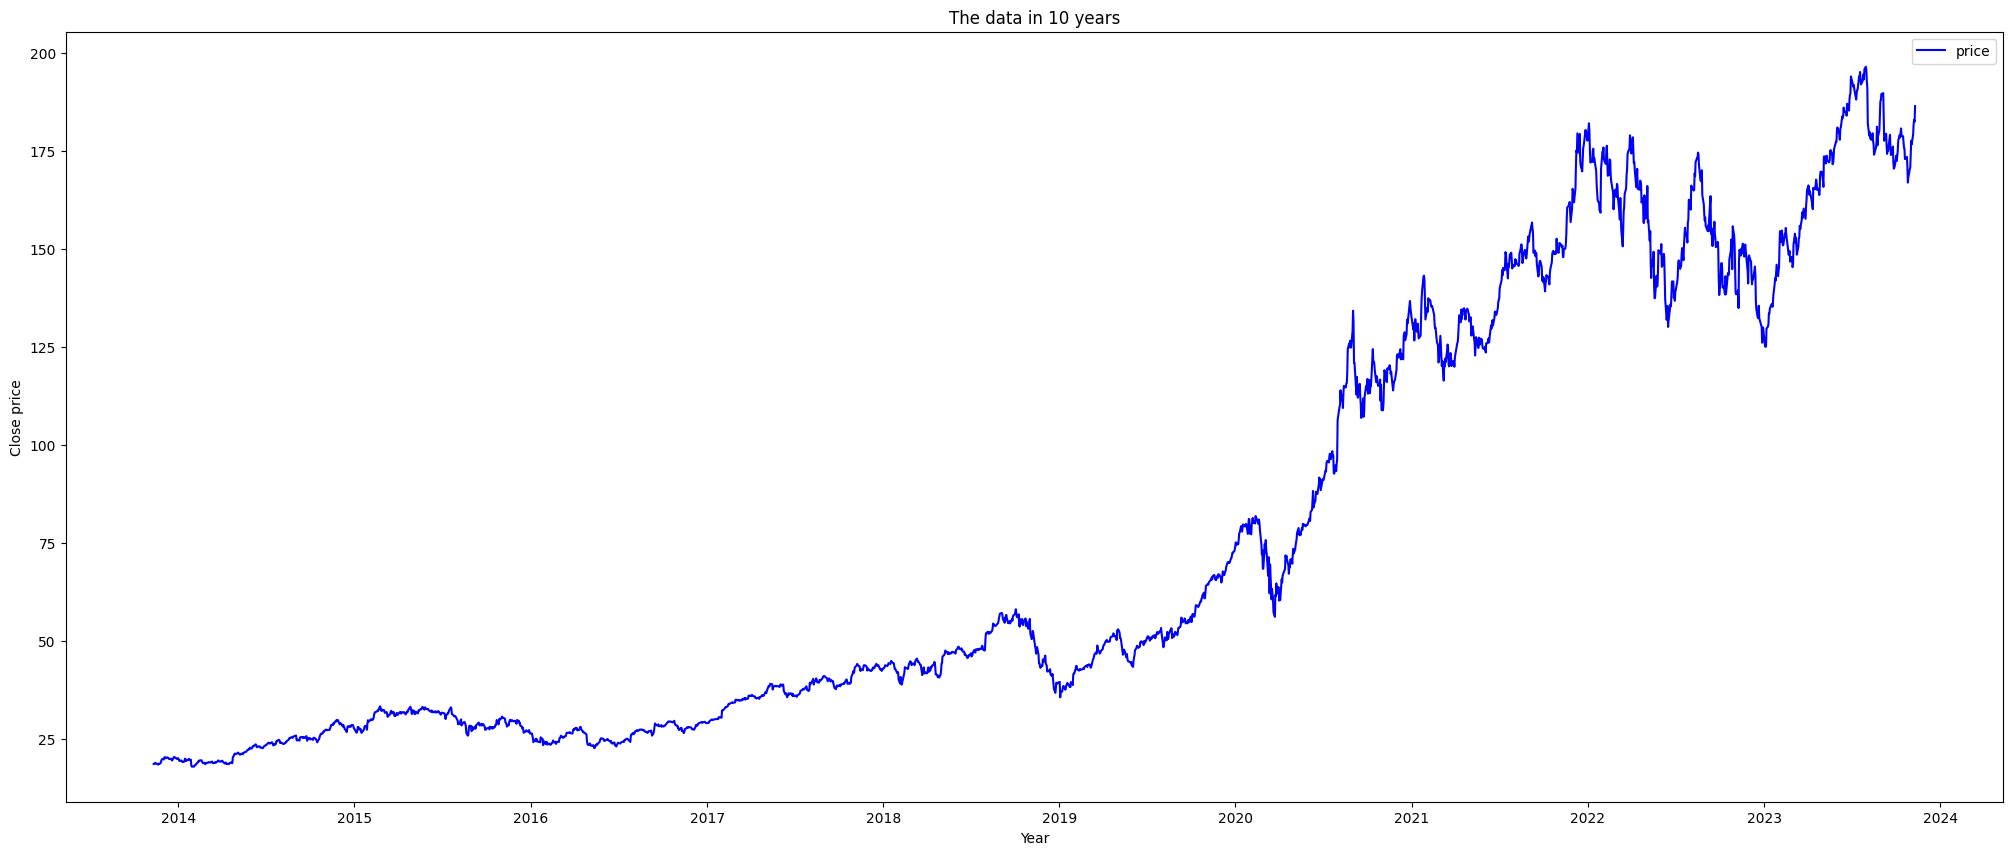

In [8]:
x_value = df.index
y_value = df['Close'].values
# visualisation
plt.figure(figsize = (25,10))
plt.plot(x_value,y_value, color = "b", label = "price" )
plt.xlabel("Year")
plt.ylabel("Close price")
plt.title("The data in 10 years")
plt.legend()
plt.show()

**Pre-procesing**

In [9]:
df = df.reset_index(level=0)

In [10]:
ratio = 0.8
len_train = round(len(df) * ratio)
len_val= len(df) - len_train
print("Data size:", len(df))
print("Train data size:", len_train)
print("Validation data size:", len_val)

Data size: 2518
Train data size: 2014
Validation data size: 504


In [11]:
train_df = df[:len_train].loc[:,['Date','Close']]
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df

,Date,Close
0,2013-11-11,18.537500
1,2013-11-12,18.571787
2,2013-11-13,18.593929
3,2013-11-14,18.862858
4,2013-11-15,18.749643
...,...,...
2009,2021-11-03,151.490005
2010,2021-11-04,150.960007
2011,2021-11-05,151.279999
2012,2021-11-08,150.440002


In [12]:
test_df = df[len_train:].loc[:,['Date','Close']]
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df

,Date,Close
2014,2021-11-10,147.919998
2015,2021-11-11,147.869995
2016,2021-11-12,149.990005
2017,2021-11-15,150.000000
2018,2021-11-16,151.000000
...,...,...
2513,2023-11-06,179.229996
2514,2023-11-07,181.820007
2515,2023-11-08,182.889999
2516,2023-11-09,182.410004


In [13]:
train_ds = np.reshape(train_df.Close.values, (-1,1))
scaler = MinMaxScaler(feature_range = (0,1))
train_dss = scaler.fit_transform(train_ds)

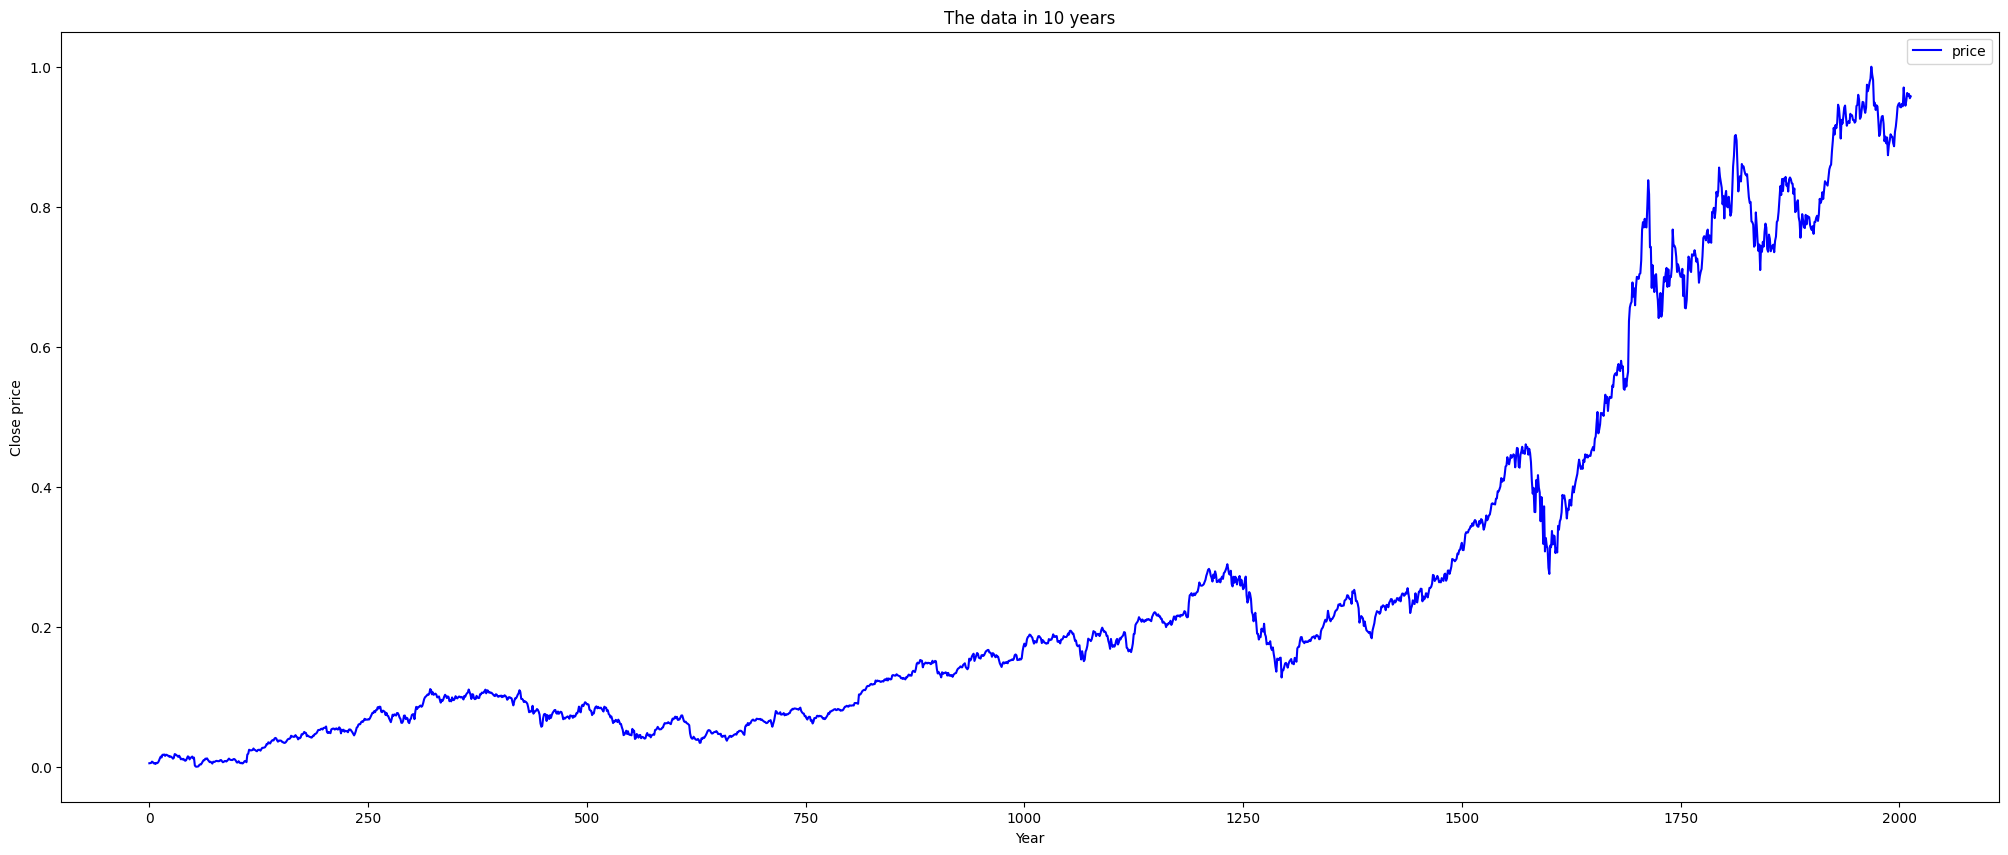

In [14]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(train_dss, color = "b", label = "price" )
plt.xlabel("Year")
plt.ylabel("Close price")
plt.title("The data in 10 years")
plt.legend()
plt.show()

In [15]:
X_train = []
y_train = []

time_step = 30

for i in range(time_step, len_train):
    X_train.append(train_dss[i-time_step:i,0])
    y_train.append(train_dss[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1984, 30, 1)
Shape of y_train before reshape : (1984, 1)


In [16]:
# Normalised
test_ds = np.reshape(test_df.Close.values, (-1,1))
#Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
test_dss = scaler.fit_transform(test_ds)
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, len_val):
    X_test.append(test_dss[i-time_step:i,0])
    y_test.append(test_dss[i,0])

# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

print("Shape of X_test :",X_test.shape)
print("Shape of y_test :",y_test.shape)

Shape of X_test : (474, 30, 1)
Shape of y_test : (474, 1)


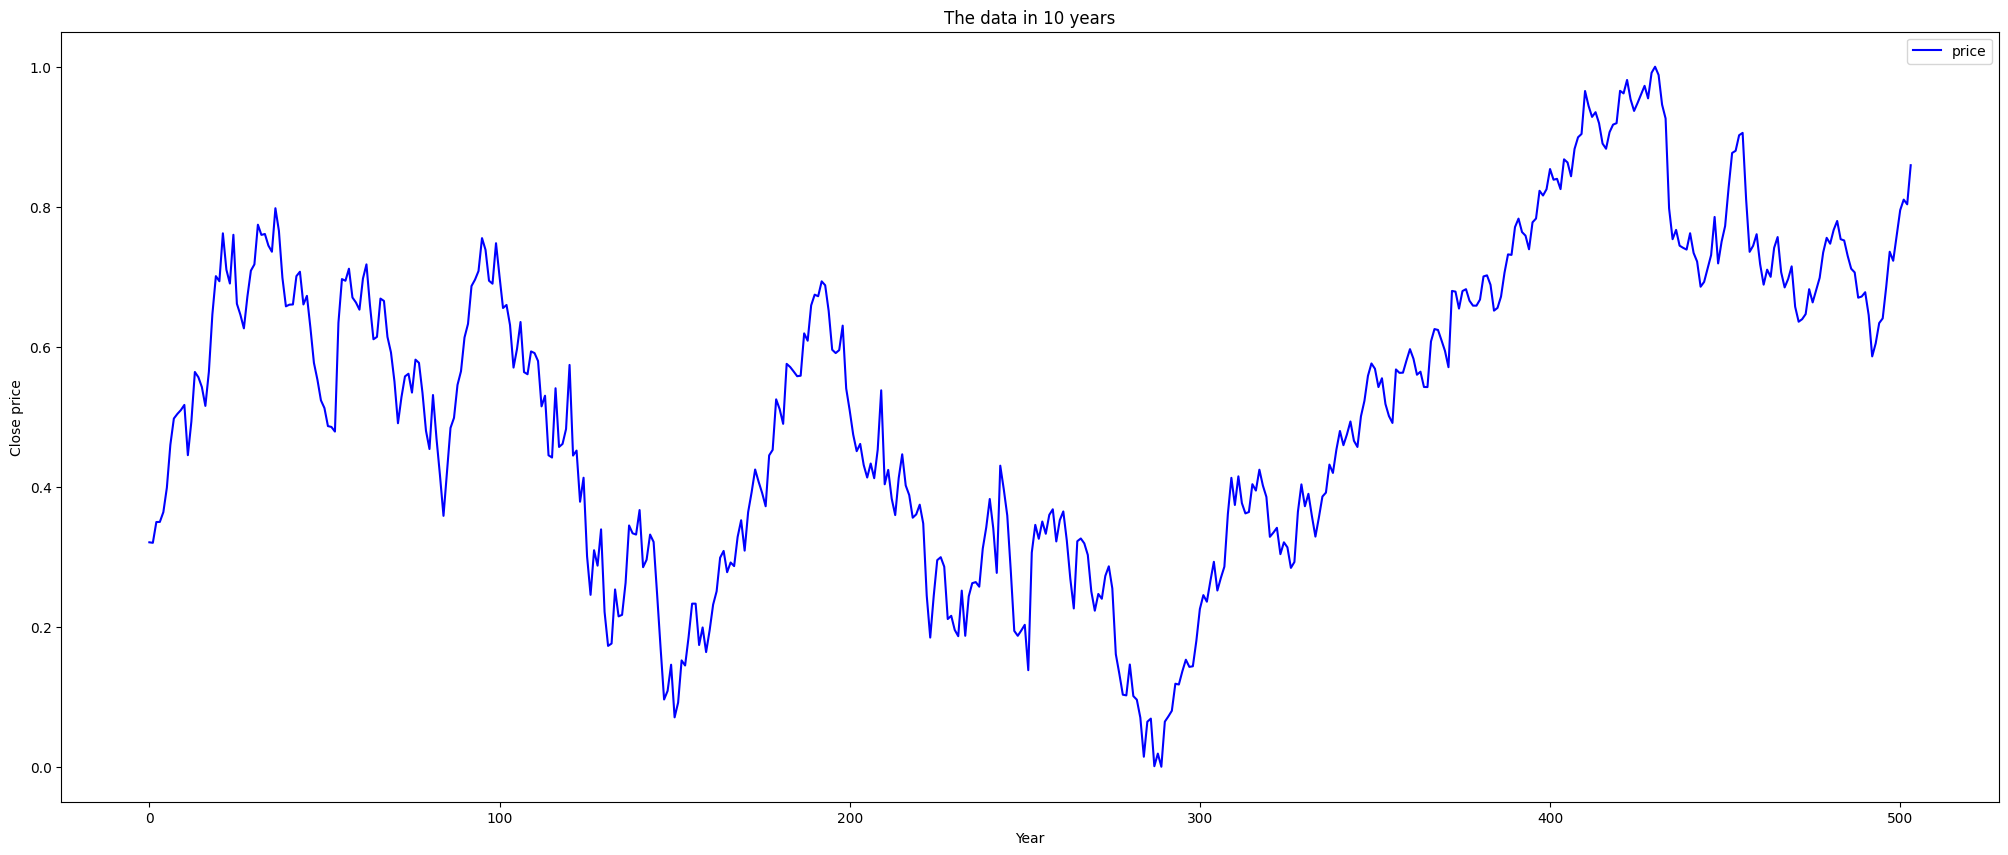

In [17]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(test_dss, color = "b", label = "price" )
plt.xlabel("Year")
plt.ylabel("Close price")
plt.title("The data in 10 years")
plt.legend()
plt.show()

**Simple RNN with learning rate 0.001**

In [18]:
# initializing the RNN
model1 = Sequential()

model1.add(SimpleRNN(units = 30,activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
model1.add(SimpleRNN(units = 30, activation = "tanh", return_sequences = True))
model1.add(SimpleRNN(units = 30, activation = "tanh", return_sequences = True))

model1.add(SimpleRNN(units = 30, activation = "tanh"))

# adding the output layer
model1.add(Dense(units = 1))

model1.summary()
# compiling RNN
adam = Adam(learning_rate=0.001)
model1.compile(optimizer = adam,loss = "mean_squared_error", metrics = ["accuracy"])

# fitting the RNN
history1 = model1.fit(X_train, y_train, epochs = 50, batch_size = 32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 30)            960       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 30)            1830      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 30, 30)            1830      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 30)                1830      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 6481 (25.32 KB)
Trainable params: 6481 (25.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
62/62 [====

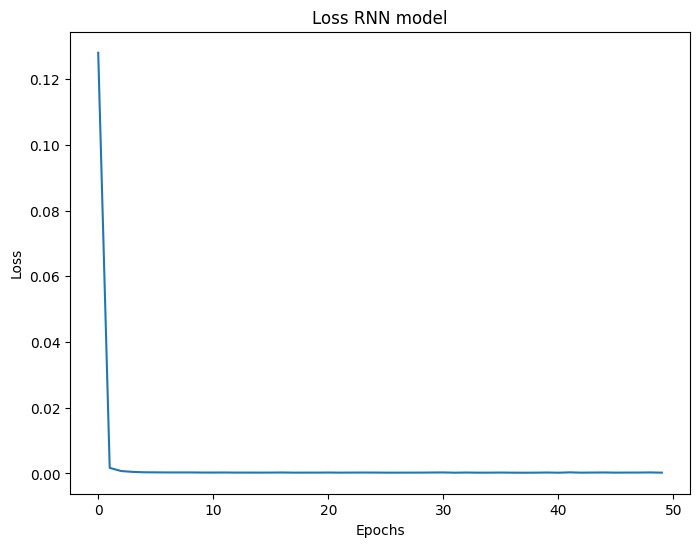

In [19]:
##loss plot
plt.figure(figsize =(8,6))
plt.plot(history1.history["loss"])

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss RNN model")
plt.show()

In [20]:
y_train_pred = model1.predict(X_train)  # predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train_original = scaler.inverse_transform(y_train)

62/62 [==============================] - 1s 4ms/step


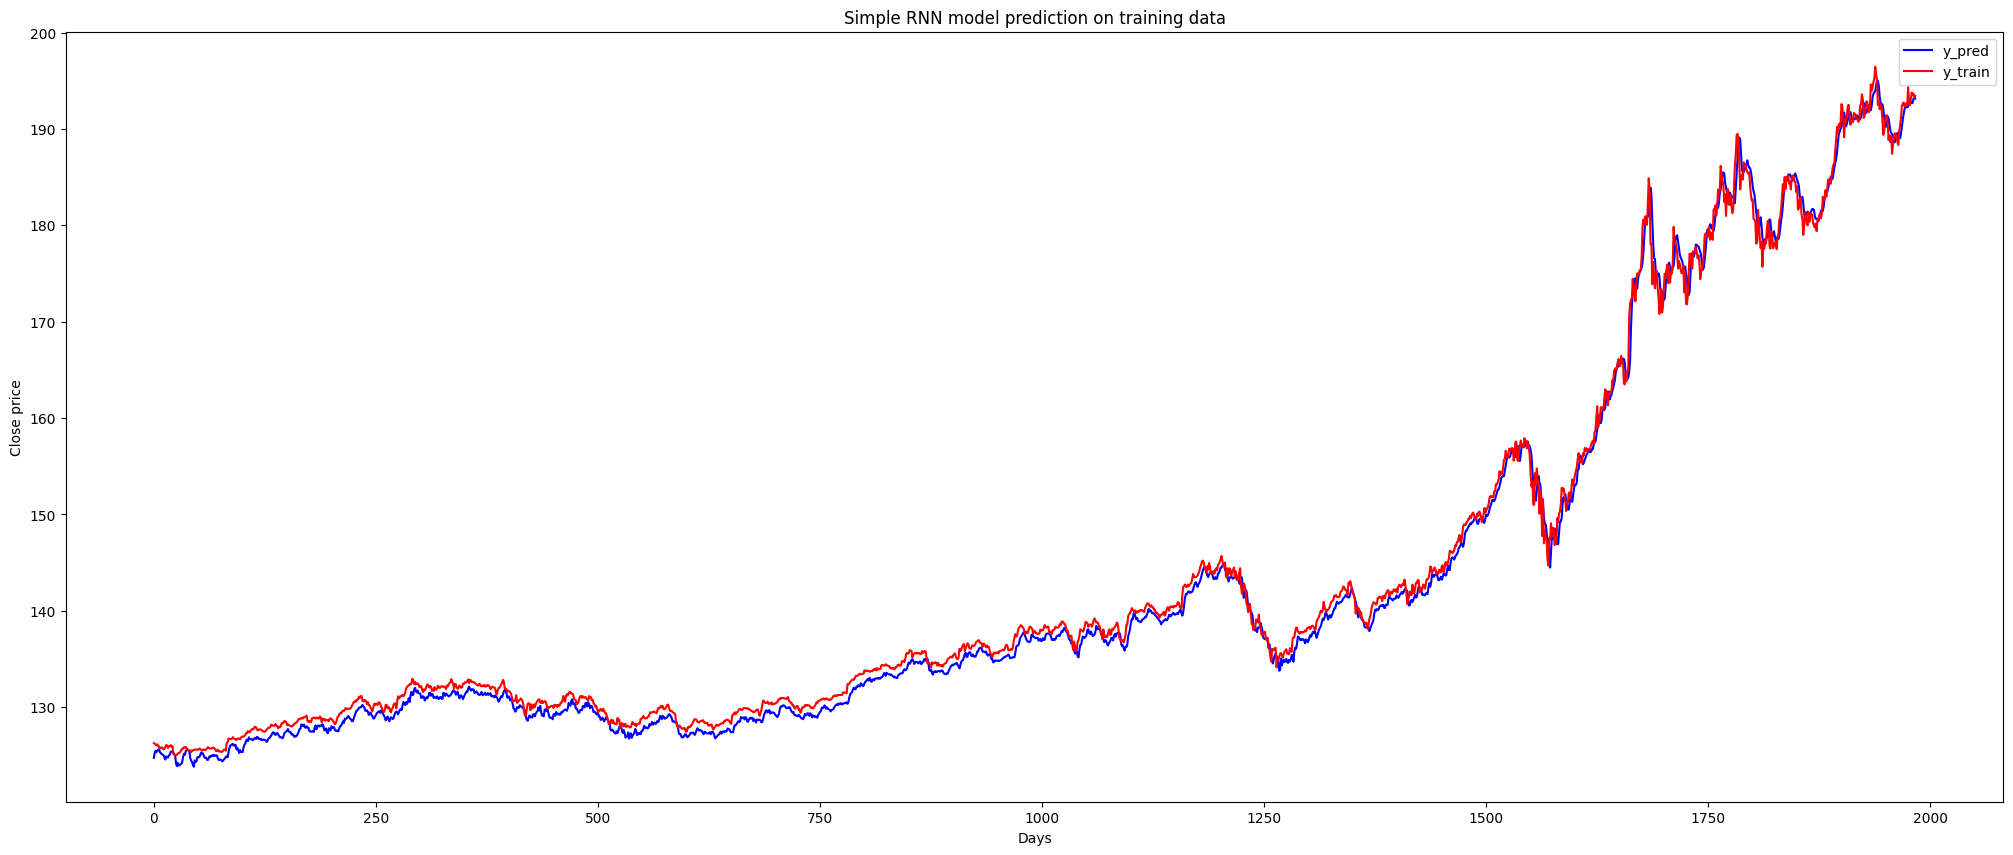

In [21]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(y_train_pred, color = "b", label = "y_pred" )
plt.plot(y_train_original , color = "r", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model prediction on training data")
plt.legend()
plt.show()

In [22]:
pred_error_train = y_train_pred - y_train_original
print(f'Max error: {np.max(np.abs(pred_error_train)):.2f}')
print(f'Min error: {np.min(np.abs(pred_error_train)):.2f}')
print(f'Mean error: {np.mean(np.abs(pred_error_train)):.2f}')

Max error: 6.54
Min error: 0.00
Mean error: 0.97


In [23]:
y_test_pred = model1.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

y_test_original = scaler.inverse_transform(y_test)
#test_pred_error = y_test_pred - scaler.inverse_transform(y_test)
test_pred_error = y_test_pred - y_test_original
print(f'Max test error: {np.max(np.abs(test_pred_error)):.2f}')
print(f'Min test error: {np.min(np.abs(test_pred_error)):.2f}')
print(f'Mean test error: {np.mean(np.abs(test_pred_error)):.2f}')

15/15 [==============================] - 0s 4ms/step
Max test error: 12.88
Min test error: 0.02
Mean test error: 3.20


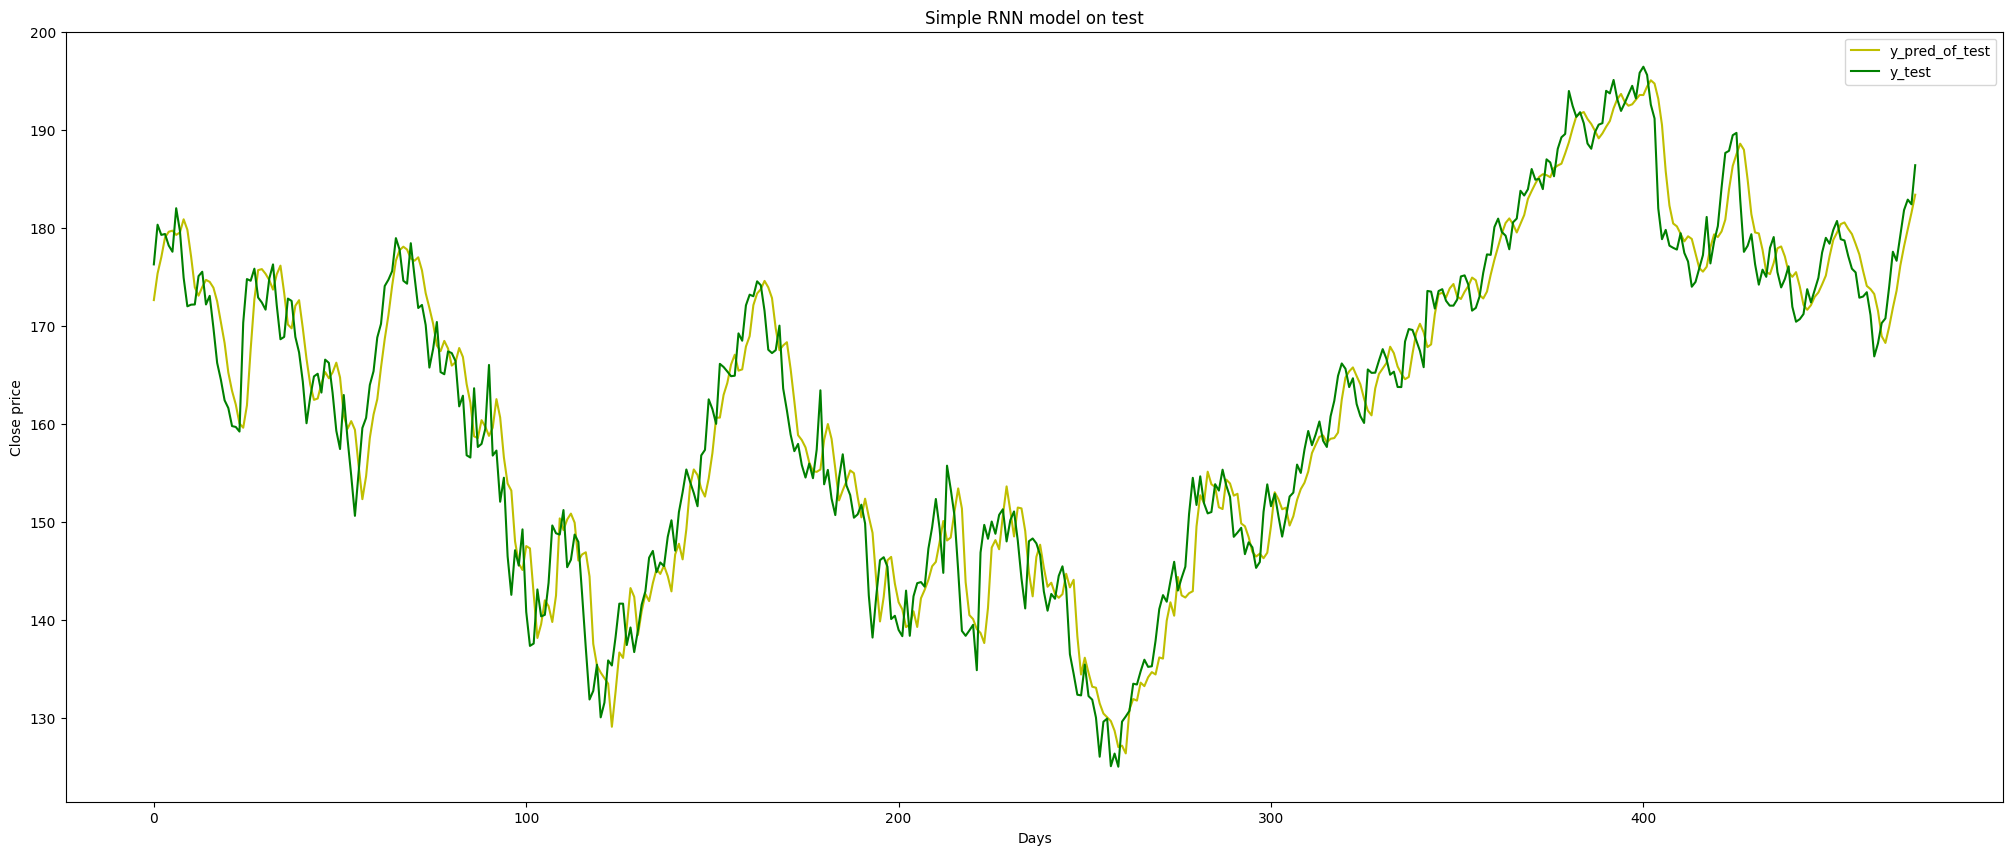

In [24]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(y_test_pred, label = "y_pred_of_test", c = "y")
plt.plot(y_test_original, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model on test")
plt.legend()
plt.show()

**Simple RNN with learning rate 0.0001**

In [25]:
# initializing the RNN
model2 = Sequential()

model2.add(SimpleRNN(units = 30,activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
model2.add(SimpleRNN(units = 30, activation = "tanh", return_sequences = True))
model2.add(SimpleRNN(units = 30, activation = "tanh"))

# adding the output layer
model2.add(Dense(units = 1))

model2.summary()
# compiling RNN
adam = Adam(learning_rate=0.0001)
model2.compile(optimizer = adam,loss = "mean_squared_error", metrics = ["accuracy"])

# fitting the RNN
history2 = model2.fit(X_train, y_train, epochs = 50, batch_size = 32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 30, 30)            960       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 30, 30)            1830      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4651 (18.17 KB)
Trainable params: 4651 (18.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
62/62 [==============================] - 2s 9ms/step - loss: 0.0190 - accuracy: 0.0010
Epoch 2/50
62/62 [==============================] - 1s

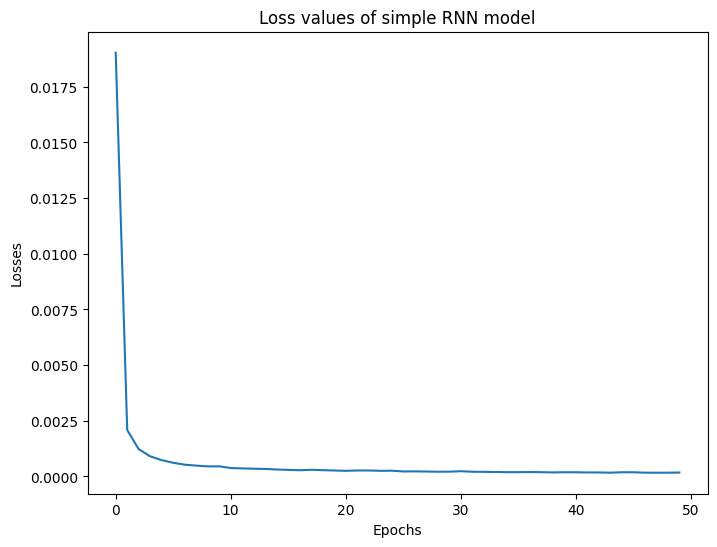

In [26]:
##loss plot

plt.figure(figsize =(8,6))
plt.plot(history2.history["loss"])

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss values of simple RNN model")
plt.show()

In [27]:
y_pred_train = model2.predict(X_train)  # predictions
y_pred_train  = scaler.inverse_transform(y_pred_train ) # scaling back from 0-1 to original

62/62 [==============================] - 0s 3ms/step


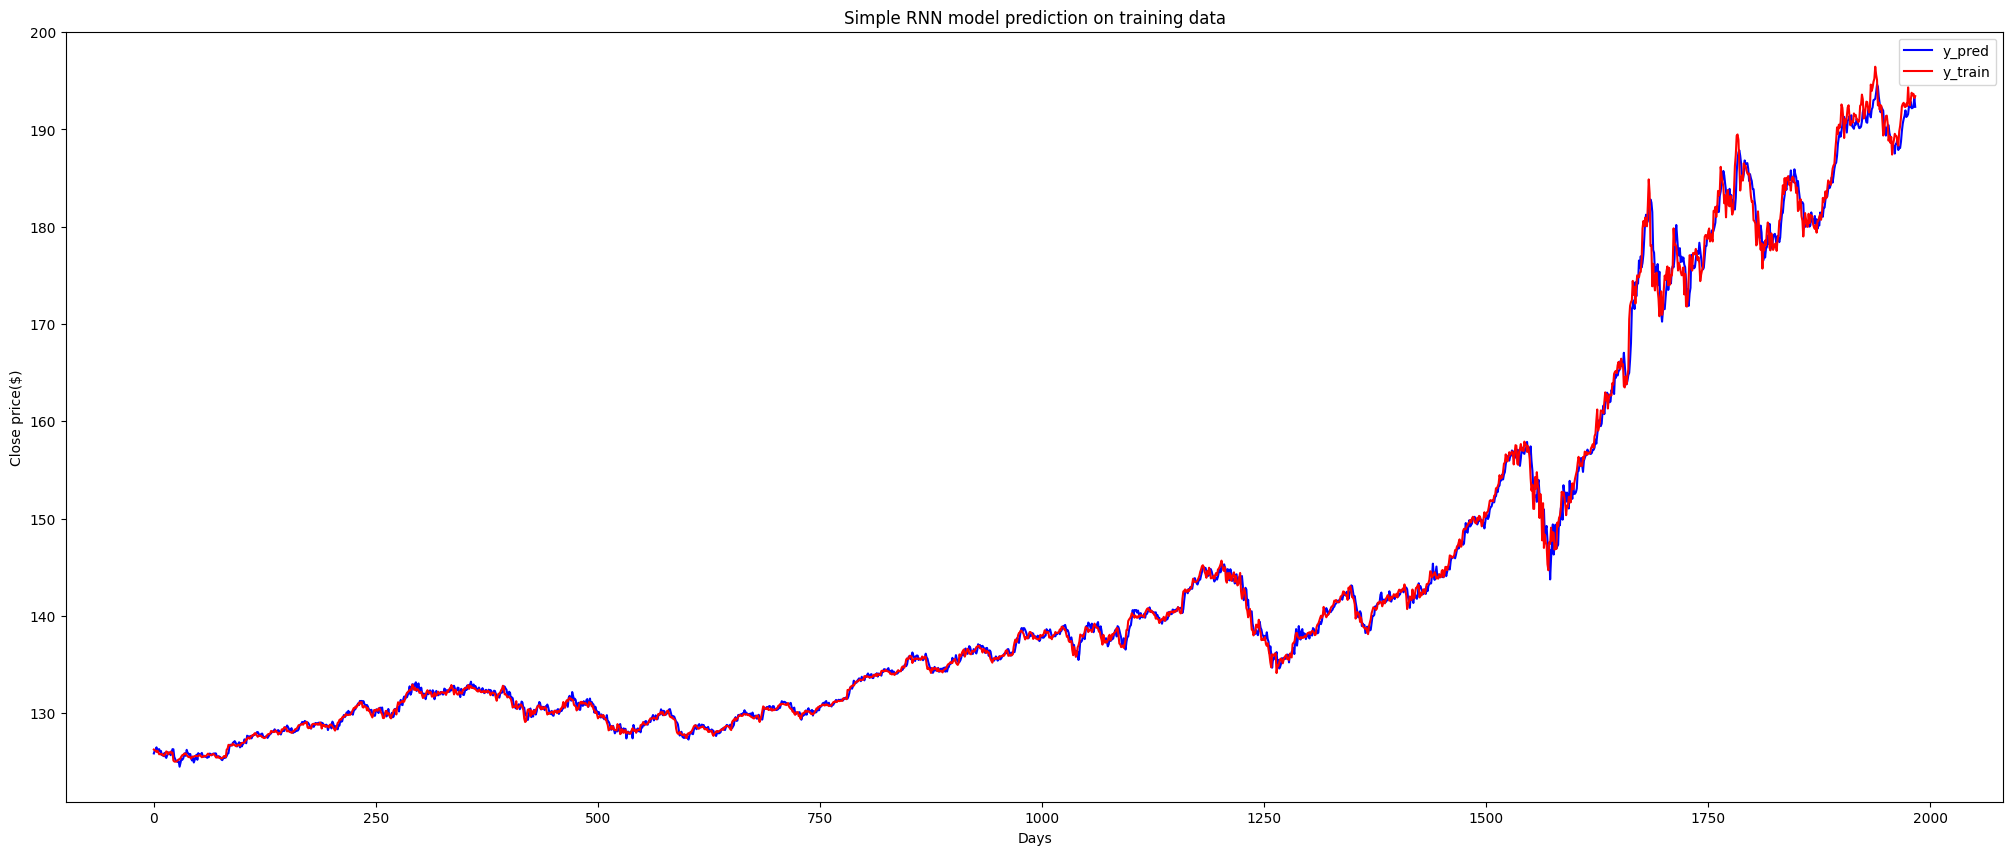

In [28]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(y_pred_train , color = "b", label = "y_pred" )
plt.plot(y_train_original , color = "r", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price($)")
plt.title("Simple RNN model prediction on training data")
plt.legend()
plt.show()

In [29]:
pred_error = y_pred_train - y_train_original
print(f'Max error: {np.max(np.abs(pred_error)):.2f}')
print(f'Min error: {np.min(np.abs(pred_error)):.2f}')
print(f'Mean error: {np.mean(np.abs(pred_error)):.2f}')

Max error: 7.63
Min error: 0.00
Mean error: 0.54


In [30]:
y_test_pred = model2.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

15/15 [==============================] - 0s 3ms/step


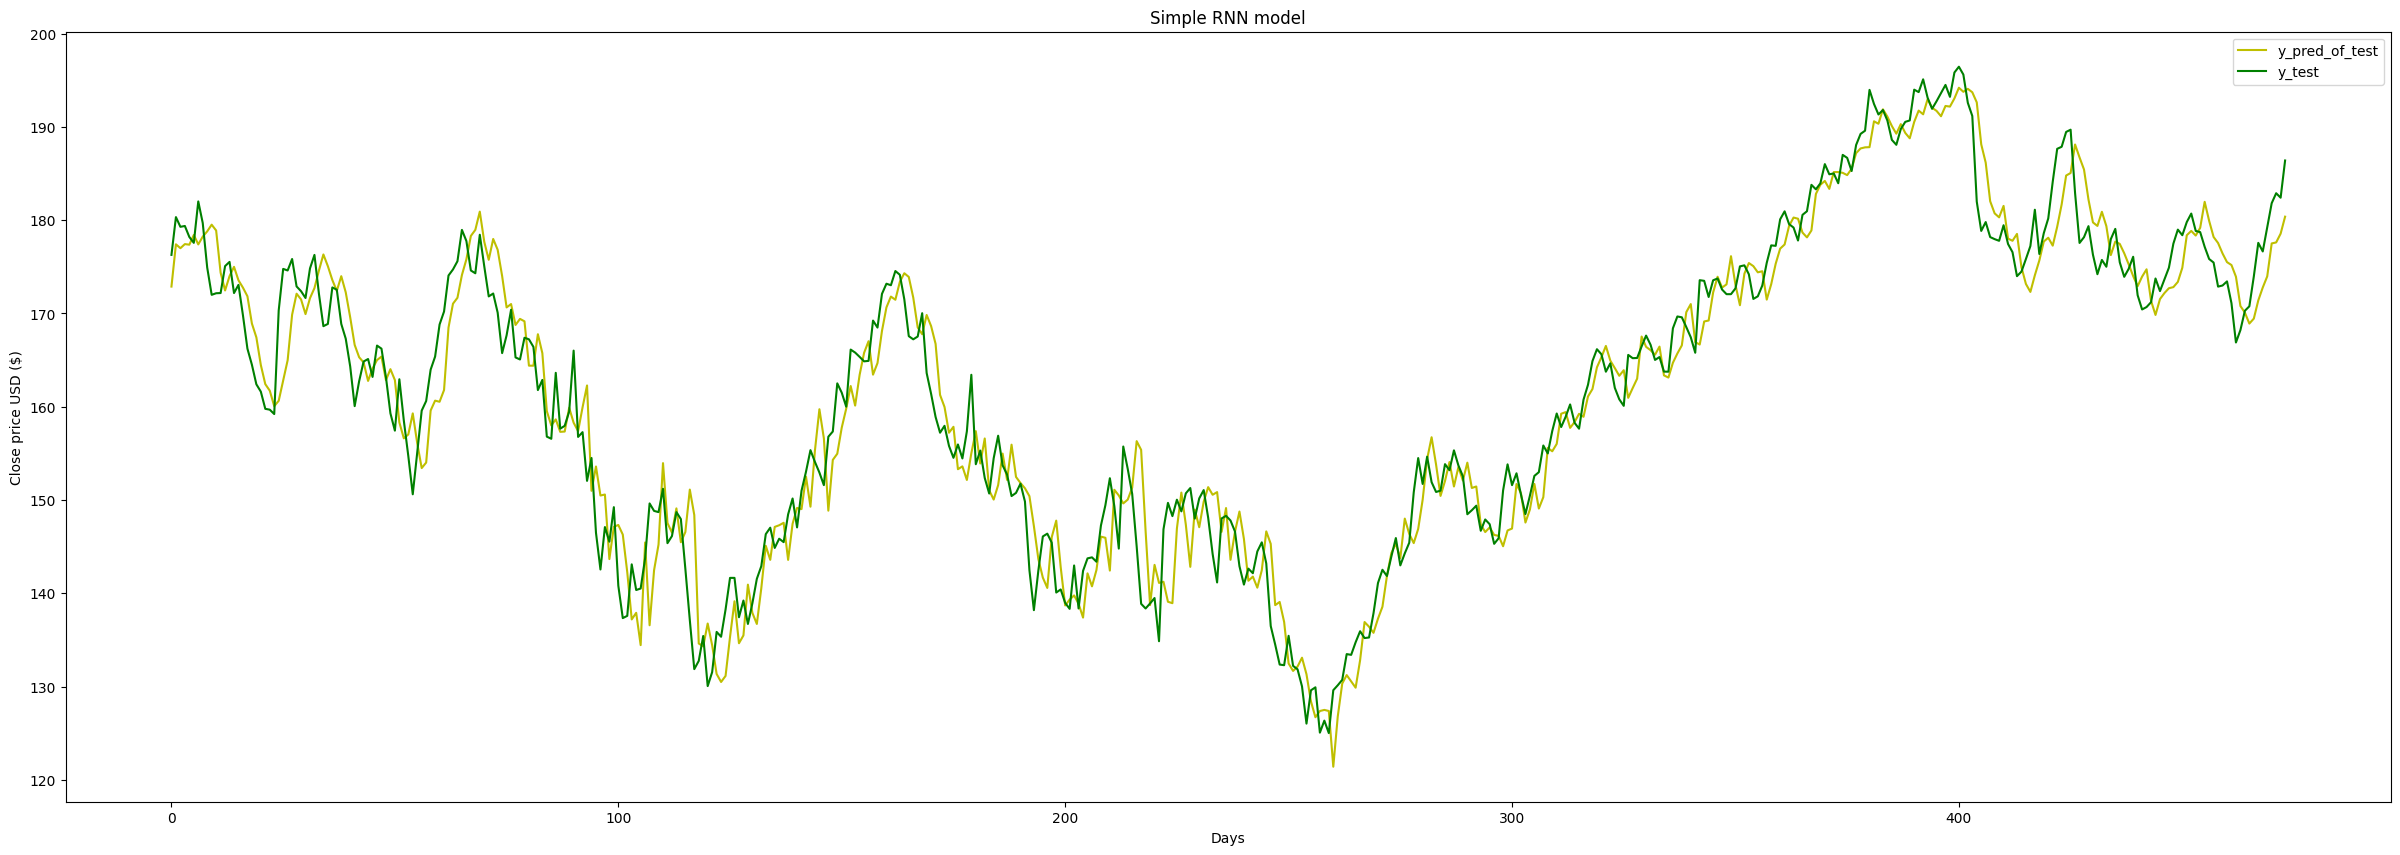

In [31]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_test_pred, label = "y_pred_of_test", c = "y")
plt.plot(y_test_original, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Close price USD ($)")
plt.title("Simple RNN model")
plt.legend()
plt.show()

In [32]:
test_pred_error = y_test_pred - y_test_original
print(f'Max test error: {np.max(np.abs(test_pred_error)):.2f}')
print(f'Min test error: {np.min(np.abs(test_pred_error)):.2f}')
print(f'Mean test error: {np.mean(np.abs(test_pred_error)):.2f}')

Max test error: 16.52
Min test error: 0.01
Mean test error: 3.32


**LSTM with learning rate 0.001**

In [33]:
from keras.optimizers import Adam

LSTM_model_1 = Sequential()
LSTM_model_1.add(LSTM(30, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)))
LSTM_model_1.add(LSTM(30, activation="tanh", return_sequences=True))
LSTM_model_1.add(LSTM(30, activation="tanh"))
LSTM_model_1.add(Dense(1))
LSTM_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18511 (72.31 KB)
Trainable params: 18511 (72.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
from keras.optimizers import Adam

LSTM_model_1 = Sequential()
LSTM_model_1.add(LSTM(30, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)))
LSTM_model_1.add(LSTM(30, activation="tanh", return_sequences=True))
LSTM_model_1.add(LSTM(30, activation="tanh"))
LSTM_model_1.add(Dense(1))

adam= Adam(learning_rate=0.001)
LSTM_model_1.compile(loss="mean_squared_error", optimizer=adam, metrics=["accuracy"])
history_1 = LSTM_model_1.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
62/62 [==============================] - 4s 16ms/step - loss: 0.0146 - accuracy: 0.0010
Epoch 2/50
62/62 [==============================] - 1s 16ms/step - loss: 6.0538e-04 - accuracy: 0.0010
Epoch 3/50
62/62 [==============================] - 1s 15ms/step - loss: 6.0486e-04 - accuracy: 0.0010
Epoch 4/50
62/62 [==============================] - 1s 16ms/step - loss: 6.0331e-04 - accuracy: 0.0010
Epoch 5/50
62/62 [==============================] - 1s 22ms/step - loss: 5.7660e-04 - accuracy: 0.0010
Epoch 6/50
62/62 [==============================] - 1s 22ms/step - loss: 6.1534e-04 - accuracy: 0.0010
Epoch 7/50
62/62 [==============================] - 1s 15ms/step - loss: 5.6630e-04 - accuracy: 0.0010
Epoch 8/50
62/62 [==============================] - 1s 15ms/step - loss: 6.9785e-04 - accuracy: 0.0010
Epoch 9/50
62/62 [==============================] - 1s 15ms/step - loss: 5.2531e-04 - accuracy: 0.0010
Epoch 10/50
62/62 [==============================] - 1s 15ms/step - loss: 4.6

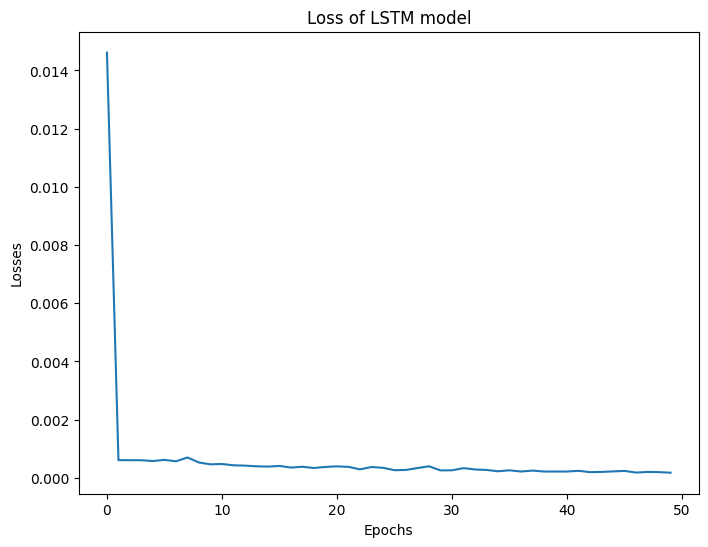

In [35]:
plt.figure(figsize =(8,6))
plt.plot(history_1.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss of LSTM model")
plt.show()

In [36]:
y_train_pred = LSTM_model_1.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)

pred_error_train = y_train_pred - y_train_original
print(f'Max error: {np.max(np.abs(pred_error_train)):.2f}')
print(f'Min error: {np.min(np.abs(pred_error_train)):.2f}')
print(f'Mean error: {np.mean(np.abs(pred_error_train)):.2f}')

62/62 [==============================] - 1s 5ms/step
Max error: 6.61
Min error: 0.00
Mean error: 0.64


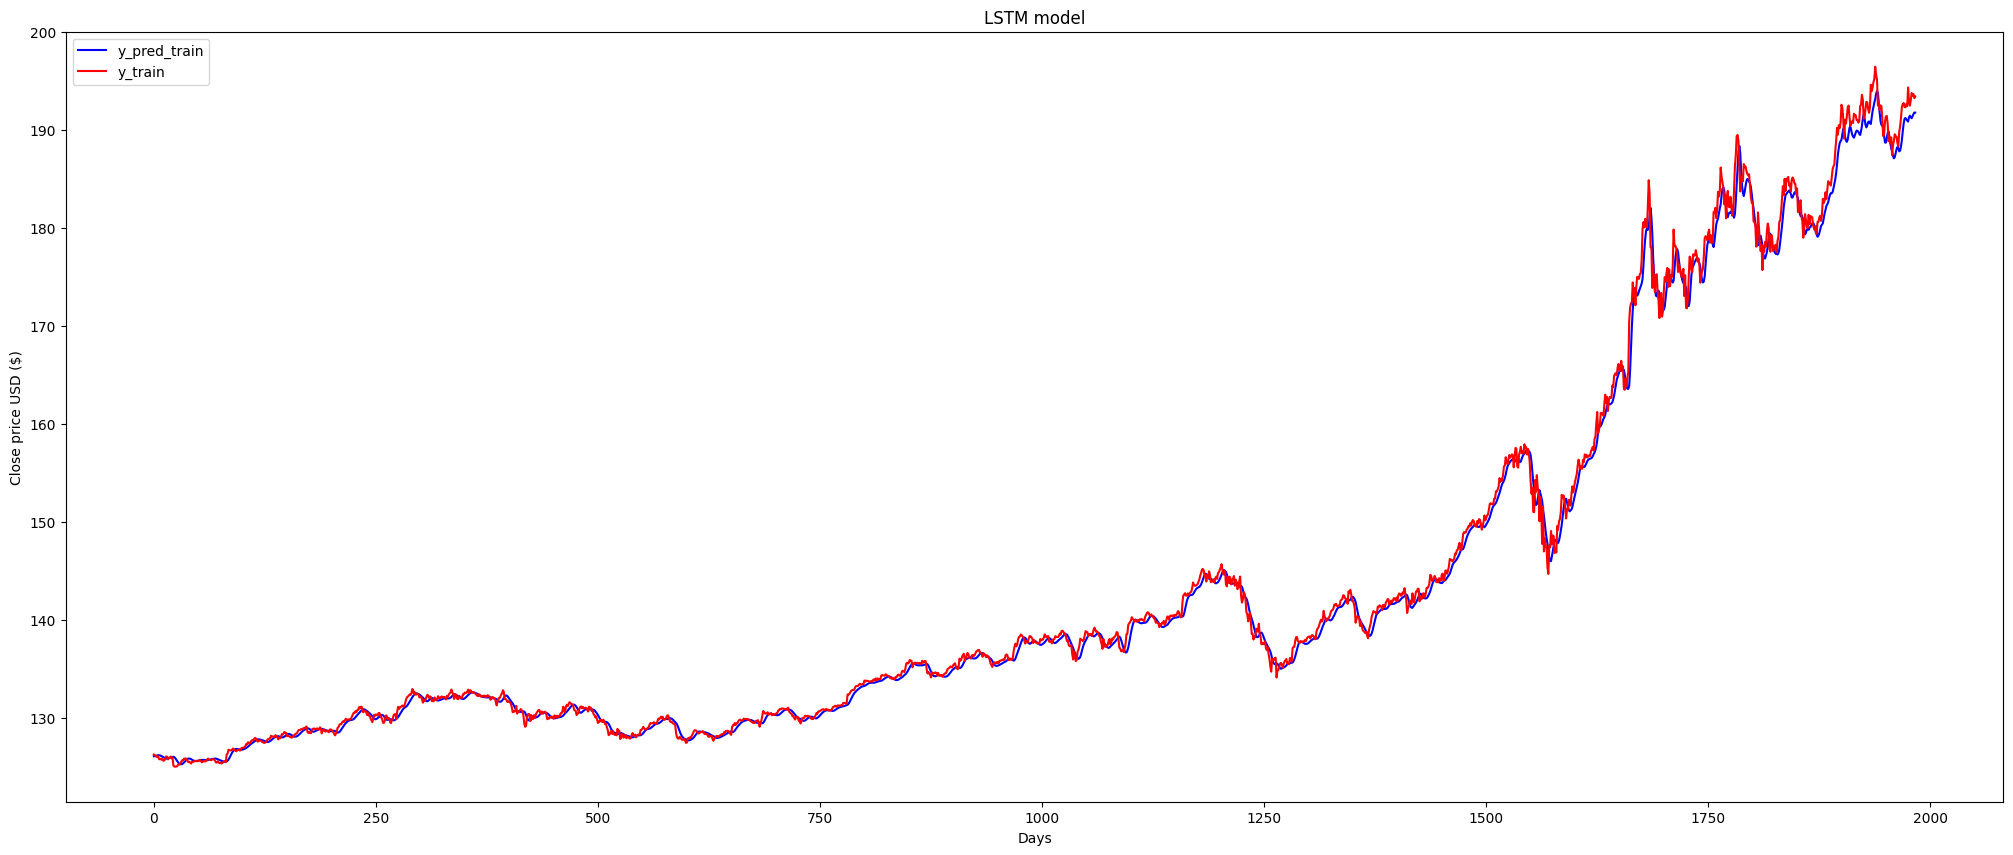

In [37]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(y_train_pred, label = "y_pred_train", c = "b")
plt.plot(y_train_original, label = "y_train", c = "r")
plt.xlabel("Days")
plt.ylabel("Close price USD ($)")
plt.title("LSTM model")
plt.legend()
plt.show()

In [38]:
y_test_pred = LSTM_model_1.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

15/15 [==============================] - 1s 6ms/step


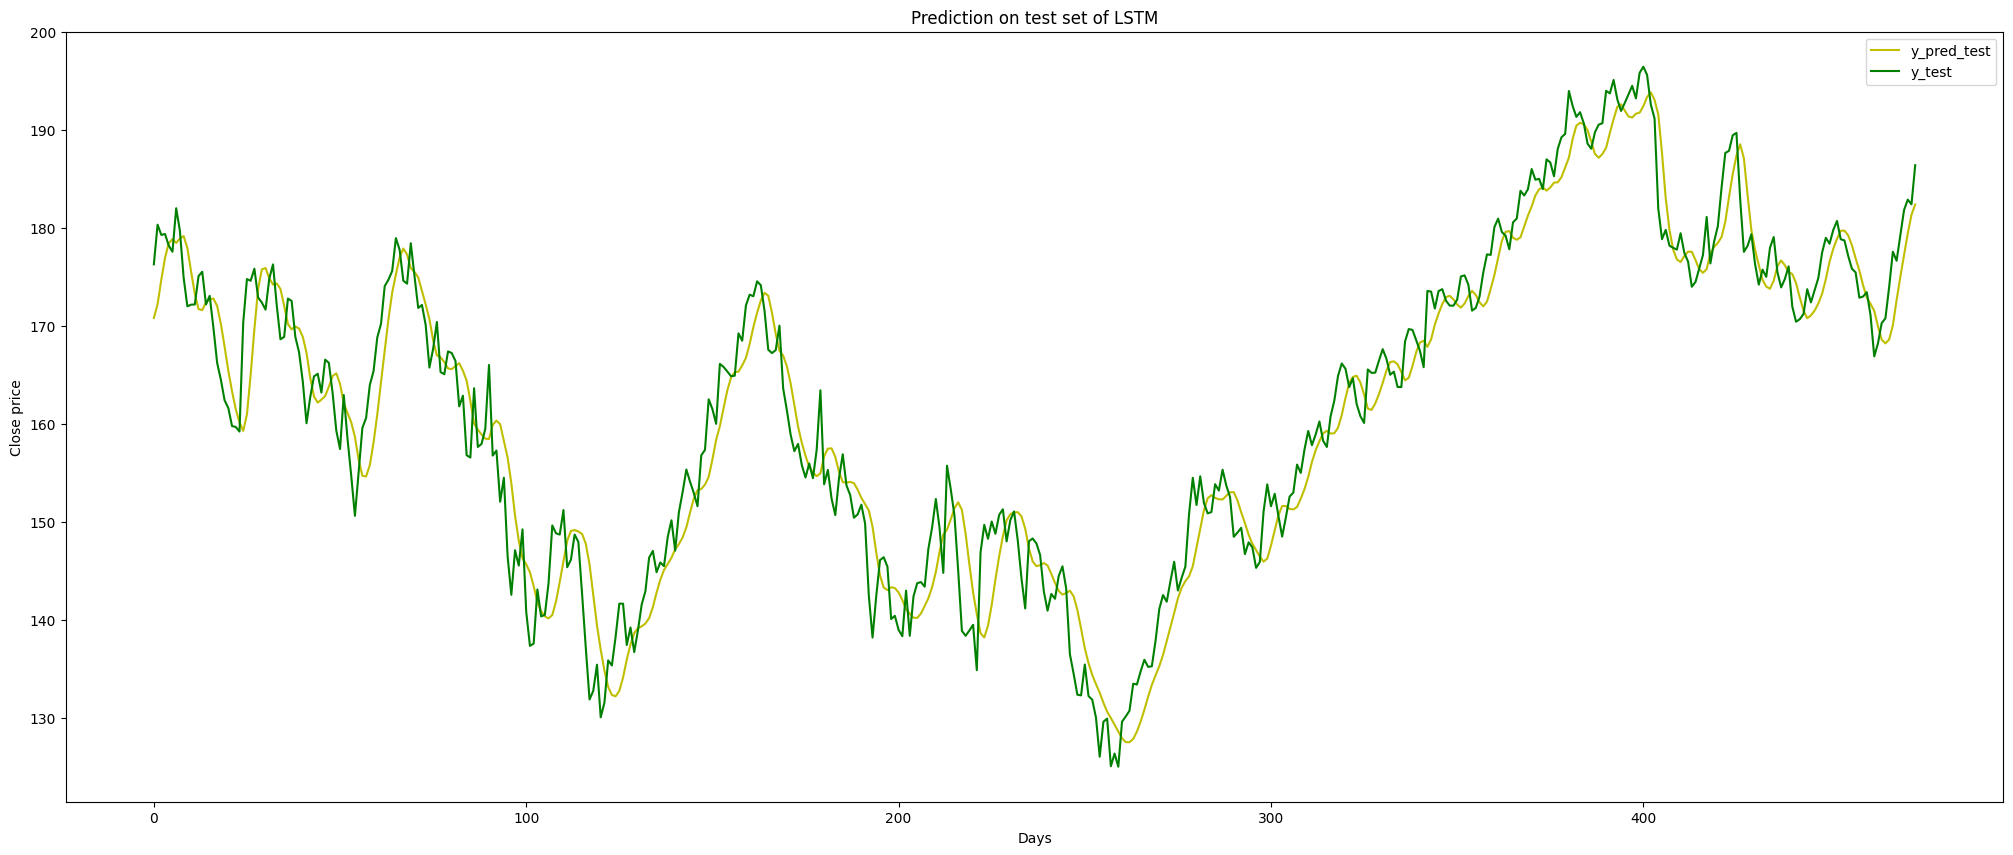

In [39]:
plt.subplots(figsize =(25,10))
plt.plot(y_test_pred, label = "y_pred_test", c = "y" )
plt.plot(y_test_original, label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Prediction on test set of LSTM")
plt.legend()
plt.show()

In [40]:
LSTM_pred_error = y_test_pred  - y_test_original
print(f'Max error: {np.max(np.abs(LSTM_pred_error)):.2f}')
print(f'Min error: {np.min(np.abs(LSTM_pred_error)):.2f}')
print(f'Mean error: {np.mean(np.abs(LSTM_pred_error)):.2f}')

Max error: 13.80
Min error: 0.04
Mean error: 3.37


**LSTM with learning rate 0.0001**

In [41]:
LSTM_model_2 = Sequential()
LSTM_model_2.add(LSTM(30, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)))
LSTM_model_2.add(LSTM(30, activation="tanh", return_sequences=True))
LSTM_model_2.add(LSTM(30, activation="tanh"))
LSTM_model_2.add(Dense(1))

adam = Adam(learning_rate=0.0001)
LSTM_model_2.compile(loss="mean_squared_error", optimizer=adam, metrics=["accuracy"])
history_2 = LSTM_model_2.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
62/62 [==============================] - 4s 18ms/step - loss: 0.0674 - accuracy: 5.0403e-04
Epoch 2/50
62/62 [==============================] - 1s 23ms/step - loss: 0.0064 - accuracy: 0.0010
Epoch 3/50
62/62 [==============================] - 1s 21ms/step - loss: 0.0010 - accuracy: 0.0010
Epoch 4/50
62/62 [==============================] - 1s 16ms/step - loss: 8.0450e-04 - accuracy: 0.0010
Epoch 5/50
62/62 [==============================] - 1s 16ms/step - loss: 7.7589e-04 - accuracy: 0.0010
Epoch 6/50
62/62 [==============================] - 1s 16ms/step - loss: 7.5937e-04 - accuracy: 0.0010
Epoch 7/50
62/62 [==============================] - 1s 17ms/step - loss: 7.4599e-04 - accuracy: 0.0010
Epoch 8/50
62/62 [==============================] - 1s 16ms/step - loss: 7.4264e-04 - accuracy: 0.0010
Epoch 9/50
62/62 [==============================] - 1s 15ms/step - loss: 7.1858e-04 - accuracy: 0.0010
Epoch 10/50
62/62 [==============================] - 1s 15ms/step - loss: 7.2747e

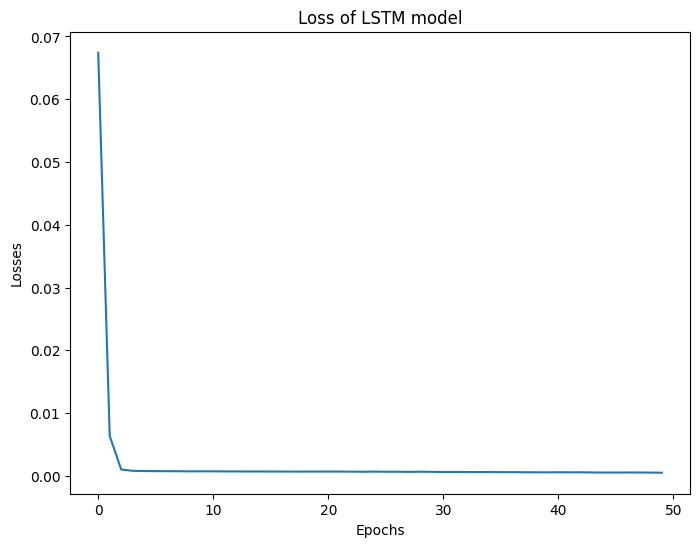

In [42]:
plt.figure(figsize =(8,6))
plt.plot(history_2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss of LSTM model")
plt.show()

In [43]:
y_train_pred = LSTM_model_2.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)

pred_error_train = y_train_pred - y_train_original
print(f'Max error: {np.max(np.abs(pred_error_train)):.2f}')
print(f'Min error: {np.min(np.abs(pred_error_train)):.2f}')
print(f'Mean error: {np.mean(np.abs(pred_error_train)):.2f}')

62/62 [==============================] - 1s 6ms/step
Max error: 8.92
Min error: 0.00
Mean error: 1.00


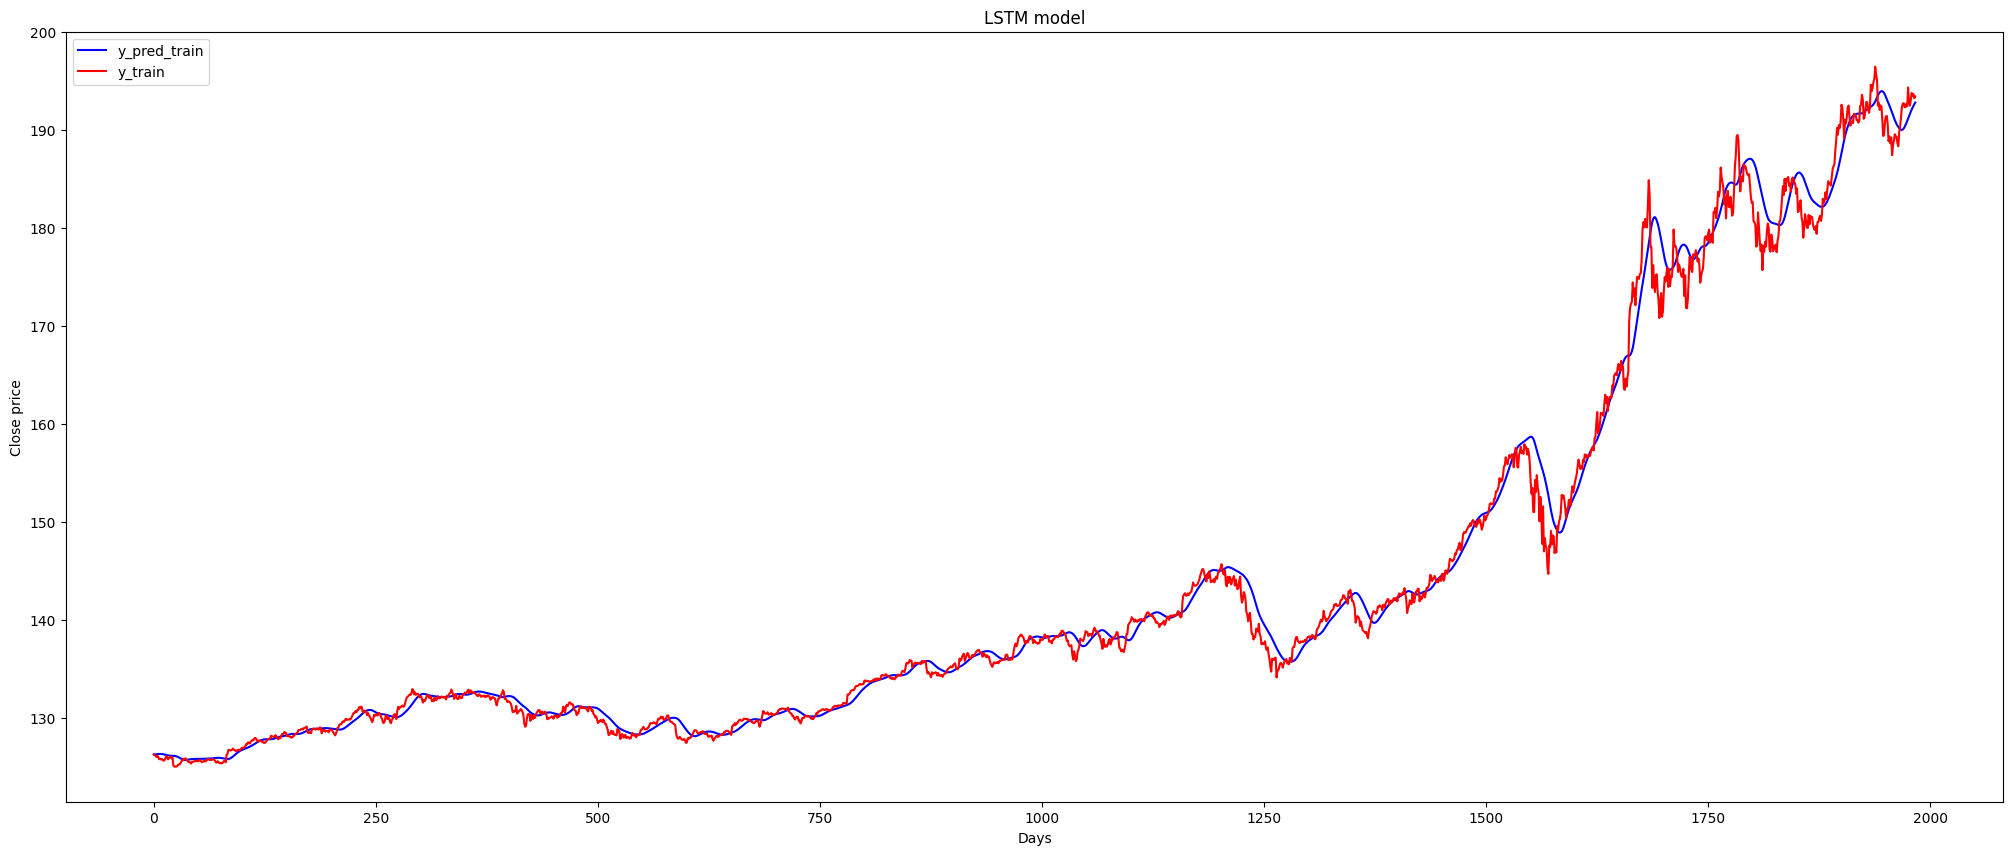

In [44]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(y_train_pred, label = "y_pred_train", c = "b")
plt.plot(y_train_original, label = "y_train", c = "r")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM model")
plt.legend()
plt.show()

In [45]:
y_test_pred = LSTM_model_2.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

15/15 [==============================] - 1s 6ms/step


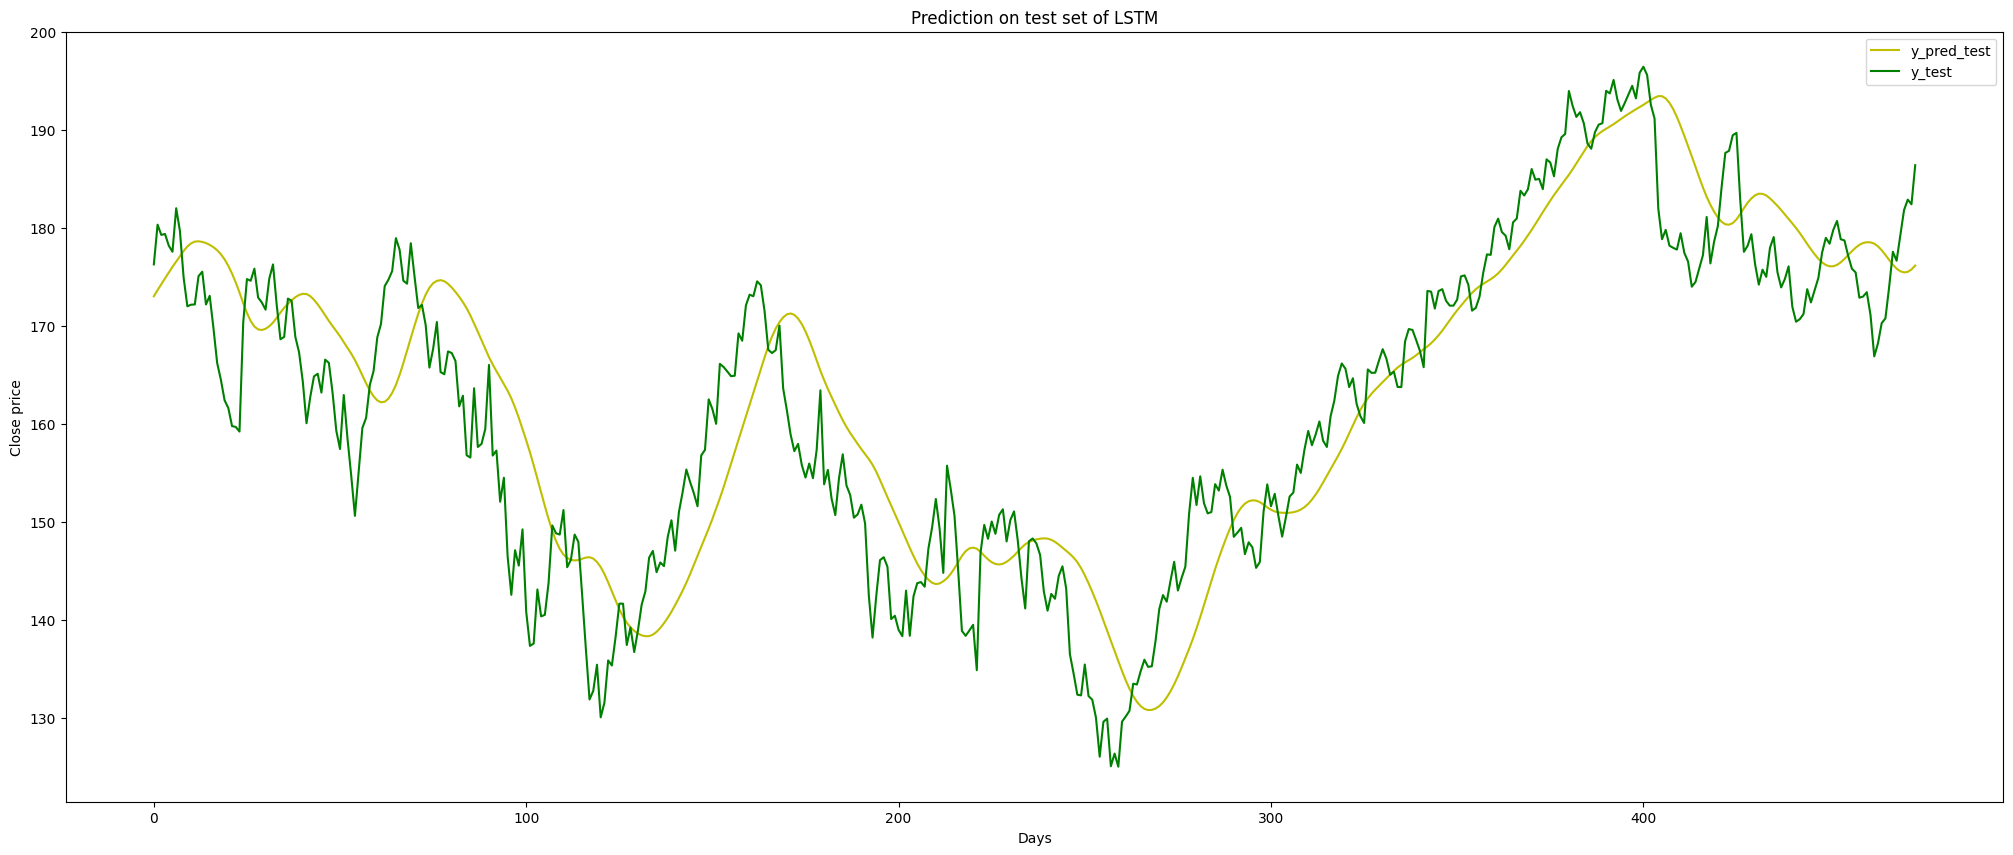

In [46]:
plt.subplots(figsize =(25,10))
plt.plot(y_test_pred, label = "y_pred_test", c = "y" )
plt.plot(y_test_original, label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Prediction on test set of LSTM")
plt.legend()
plt.show()

In [47]:
LSTM_pred_error = y_test_pred  - y_test_original
print(f'Max error: {np.max(np.abs(LSTM_pred_error)):.2f}')
print(f'Min error: {np.min(np.abs(LSTM_pred_error)):.2f}')
print(f'Mean error: {np.mean(np.abs(LSTM_pred_error)):.2f}')

Max error: 20.05
Min error: 0.01
Mean error: 6.38


**GRU with learning rate 0.001**

In [48]:
from keras.layers import GRU
from keras.optimizers import SGD, Adam

In [49]:
# The GRU architecture
GRU_model_1 = Sequential()
GRU_model_1.add(GRU(units=30, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)))
GRU_model_1.add(GRU(units=30, activation="tanh", return_sequences=True))
GRU_model_1.add(GRU(units=30, activation="tanh"))
GRU_model_1.add(Dense(units=1))
GRU_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 30)            2970      
                                                                 
 gru_1 (GRU)                 (None, 30, 30)            5580      
                                                                 
 gru_2 (GRU)                 (None, 30)                5580      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 14161 (55.32 KB)
Trainable params: 14161 (55.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# The GRU architecture
GRU_model_1 = Sequential()
GRU_model_1.add(GRU(units=30, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)))
GRU_model_1.add(GRU(units=30, activation="tanh", return_sequences=True))
GRU_model_1.add(GRU(units=30, activation="tanh"))
GRU_model_1.add(Dense(units=1))

adam = Adam(learning_rate=0.001)
GRU_model_1.compile(loss="mean_squared_error", optimizer=adam, metrics=["accuracy"])
history_gru_1 = GRU_model_1.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
62/62 [==============================] - 4s 15ms/step - loss: 0.0068 - accuracy: 0.0010
Epoch 2/50
62/62 [==============================] - 1s 14ms/step - loss: 2.4669e-04 - accuracy: 0.0010
Epoch 3/50
62/62 [==============================] - 1s 14ms/step - loss: 2.0711e-04 - accuracy: 0.0010
Epoch 4/50
62/62 [==============================] - 1s 14ms/step - loss: 1.9645e-04 - accuracy: 0.0010
Epoch 5/50
62/62 [==============================] - 1s 15ms/step - loss: 1.9707e-04 - accuracy: 0.0010
Epoch 6/50
62/62 [==============================] - 1s 22ms/step - loss: 1.6957e-04 - accuracy: 0.0010
Epoch 7/50
62/62 [==============================] - 1s 21ms/step - loss: 1.5381e-04 - accuracy: 0.0010
Epoch 8/50
62/62 [==============================] - 1s 14ms/step - loss: 1.5785e-04 - accuracy: 0.0010
Epoch 9/50
62/62 [==============================] - 1s 15ms/step - loss: 1.5572e-04 - accuracy: 0.0010
Epoch 10/50
62/62 [==============================] - 1s 15ms/step - loss: 1.3

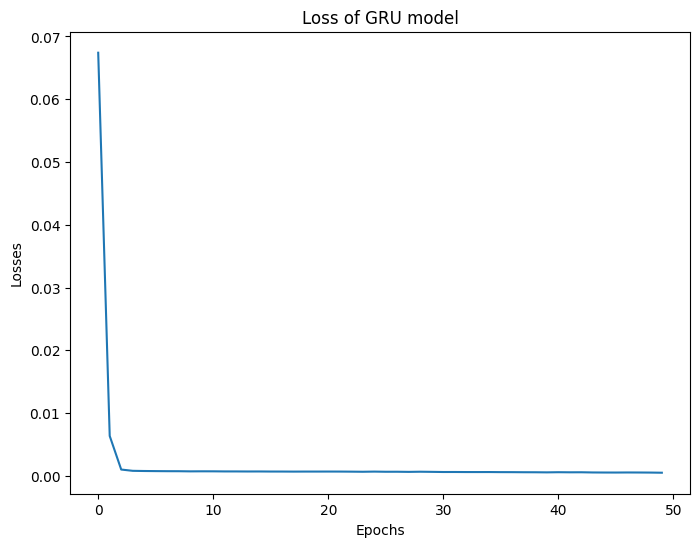

In [51]:
plt.figure(figsize =(8,6))
plt.plot(history_2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss of GRU model")
plt.show()

In [52]:
y_train_pred = GRU_model_1.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)

pred_error_train = y_train_pred - y_train_original
print(f'Max error: {np.max(np.abs(pred_error_train)):.2f}')
print(f'Min error: {np.min(np.abs(pred_error_train)):.2f}')
print(f'Mean error: {np.mean(np.abs(pred_error_train)):.2f}')

62/62 [==============================] - 1s 5ms/step
Max error: 6.28
Min error: 0.00
Mean error: 0.46


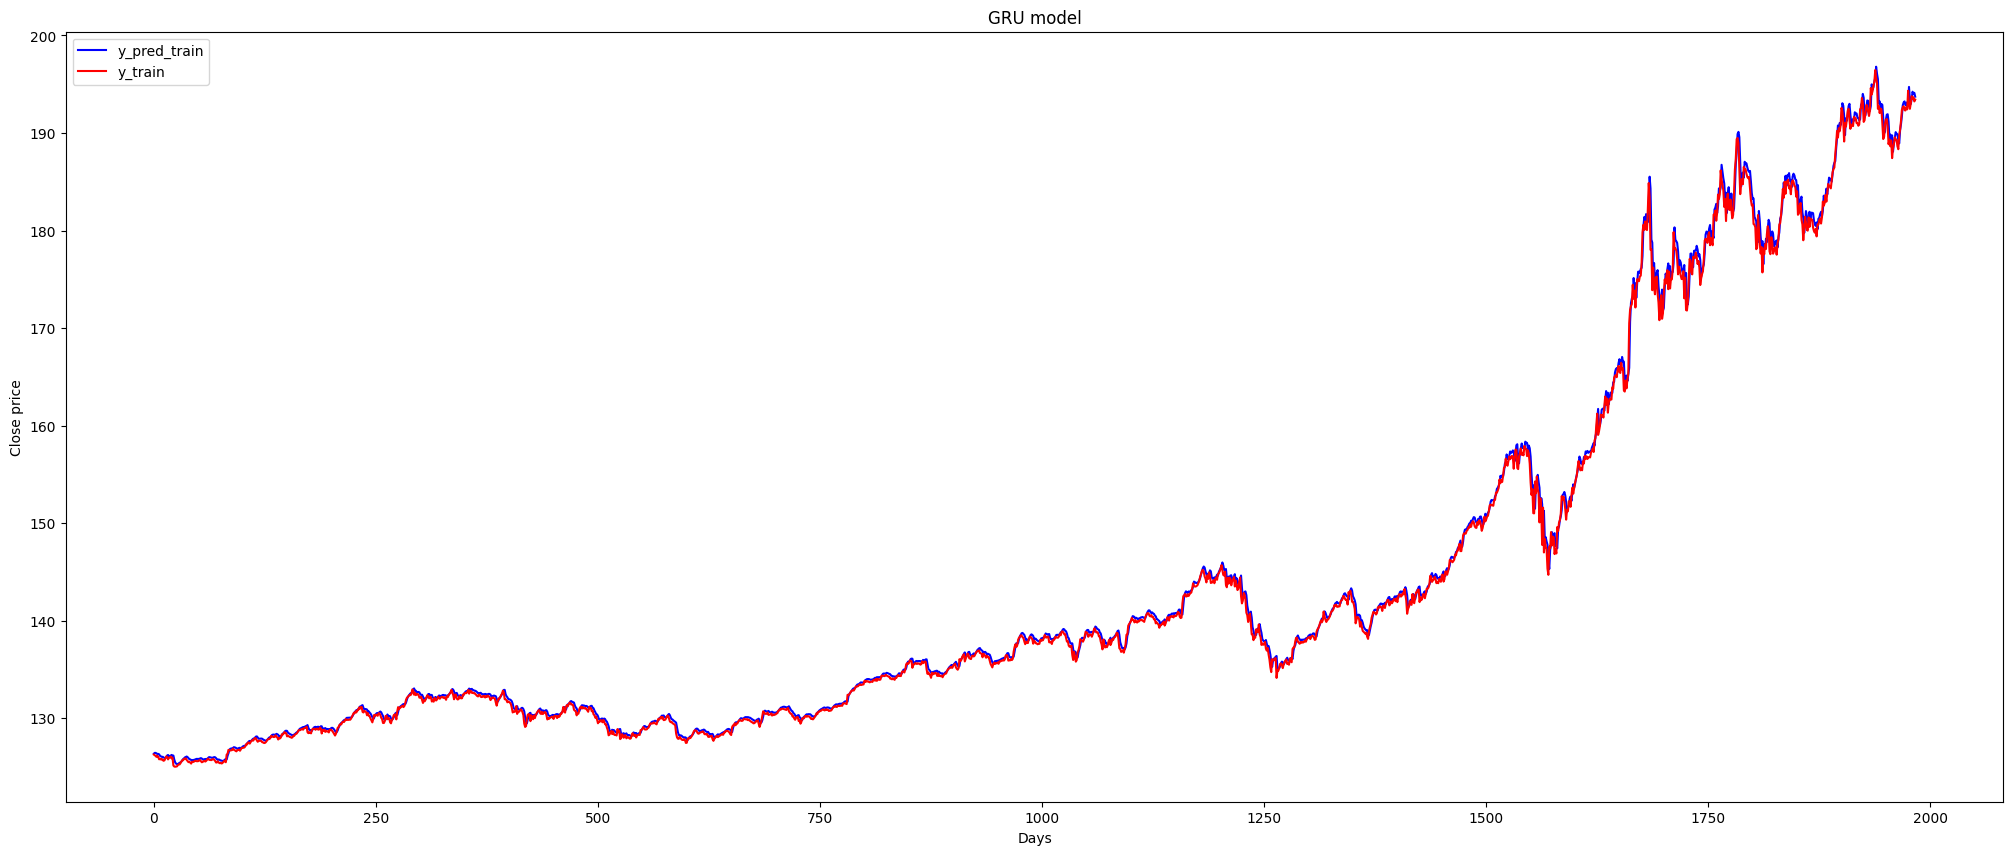

In [53]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(y_train_pred, label = "y_pred_train", c = "b")
plt.plot(y_train_original, label = "y_train", c = "r")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("GRU model")
plt.legend()
plt.show()

In [54]:
y_test_pred = GRU_model_1.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

15/15 [==============================] - 1s 5ms/step


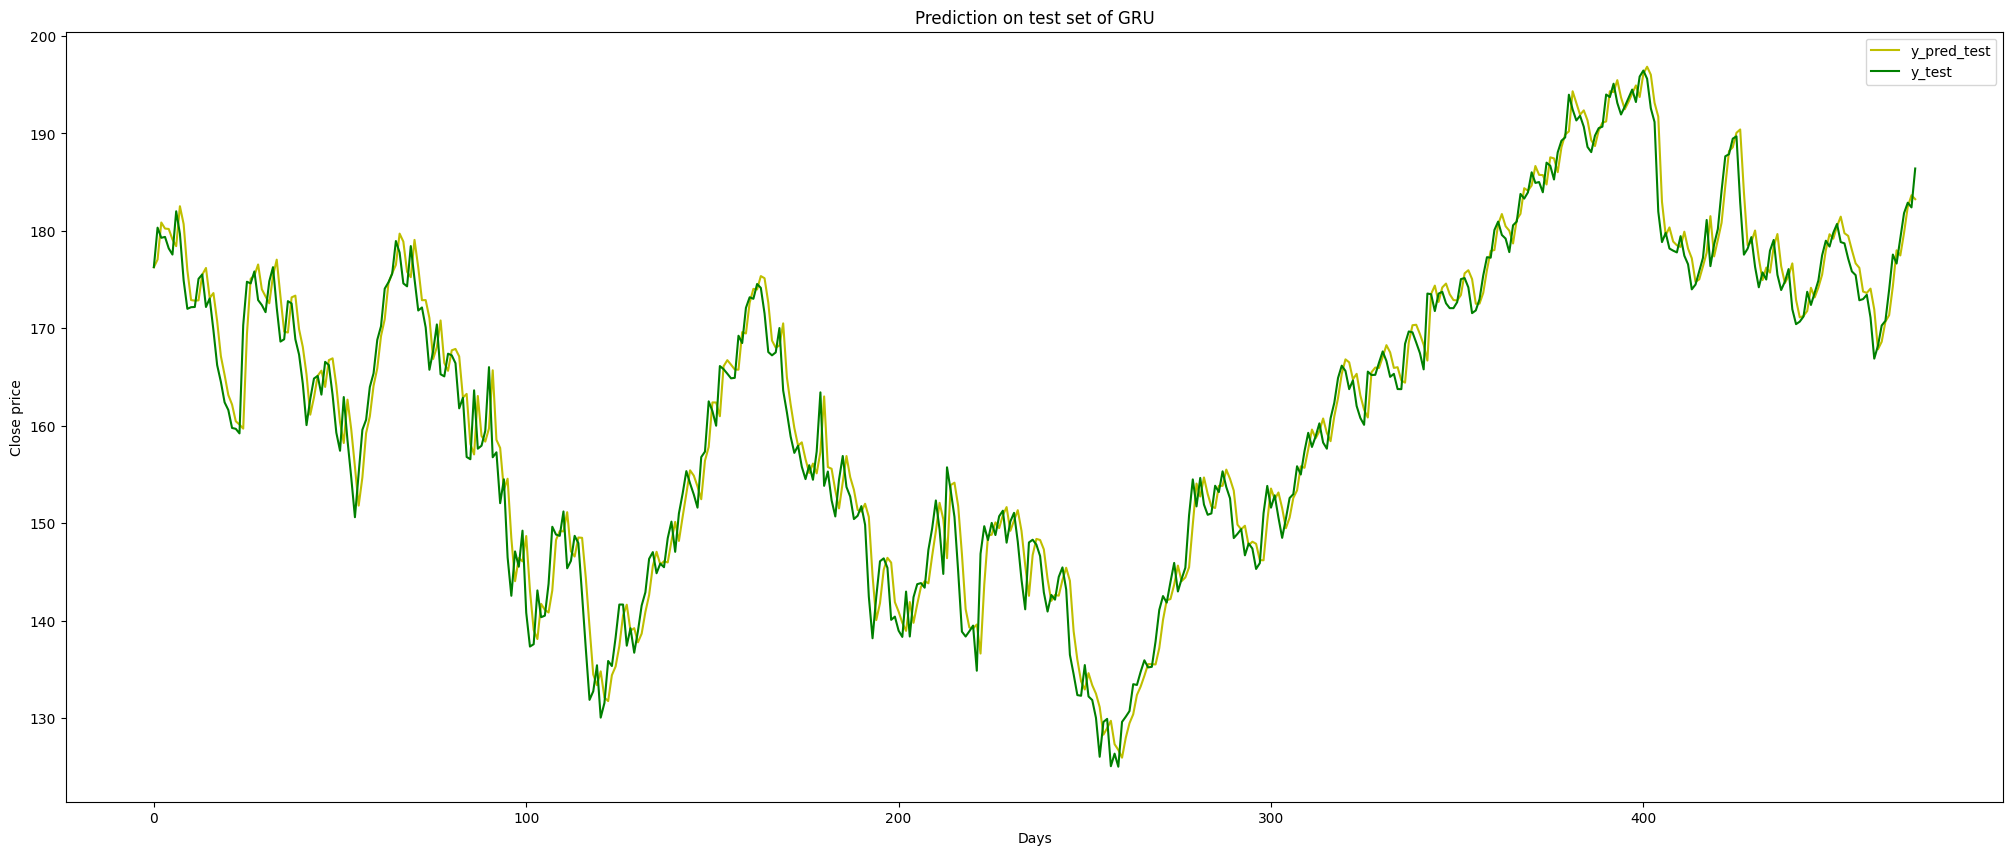

In [55]:
plt.subplots(figsize =(25,10))
plt.plot(y_test_pred, label = "y_pred_test", c = "y" )
plt.plot(y_test_original, label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Prediction on test set of GRU")
plt.legend()
plt.show()

In [56]:
GRU_pred_error = y_test_pred  - y_test_original
print(f'Max error: {np.max(np.abs(GRU_pred_error)):.2f}')
print(f'Min error: {np.min(np.abs(GRU_pred_error)):.2f}')
print(f'Mean error: {np.mean(np.abs(GRU_pred_error)):.2f}')

Max error: 10.62
Min error: 0.00
Mean error: 2.34


**GRU with learning rate 0.0001**

In [57]:
adam_01 = Adam(learning_rate=0.0001)

GRU_model_2 = Sequential()
GRU_model_2.add(GRU(units=30, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)))
GRU_model_2.add(GRU(units=30, activation="tanh", return_sequences=True))
GRU_model_2.add(GRU(units=30, activation="tanh"))
GRU_model_2.add(Dense(units=1))

adam = Adam(learning_rate=0.0001)

GRU_model_2.compile(loss="mean_squared_error", optimizer=adam, metrics=["accuracy"])
history_gru_2 = GRU_model_2.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
62/62 [==============================] - 4s 15ms/step - loss: 0.1079 - accuracy: 5.0403e-04
Epoch 2/50
62/62 [==============================] - 1s 21ms/step - loss: 0.0264 - accuracy: 0.0010
Epoch 3/50
62/62 [==============================] - 1s 21ms/step - loss: 0.0081 - accuracy: 0.0010
Epoch 4/50
62/62 [==============================] - 1s 14ms/step - loss: 9.8655e-04 - accuracy: 0.0010
Epoch 5/50
62/62 [==============================] - 1s 14ms/step - loss: 2.8896e-04 - accuracy: 0.0010
Epoch 6/50
62/62 [==============================] - 1s 14ms/step - loss: 2.7870e-04 - accuracy: 0.0010
Epoch 7/50
62/62 [==============================] - 1s 14ms/step - loss: 2.7666e-04 - accuracy: 0.0010
Epoch 8/50
62/62 [==============================] - 1s 15ms/step - loss: 2.7055e-04 - accuracy: 0.0010
Epoch 9/50
62/62 [==============================] - 1s 14ms/step - loss: 2.6787e-04 - accuracy: 0.0010
Epoch 10/50
62/62 [==============================] - 1s 15ms/step - loss: 2.6770e

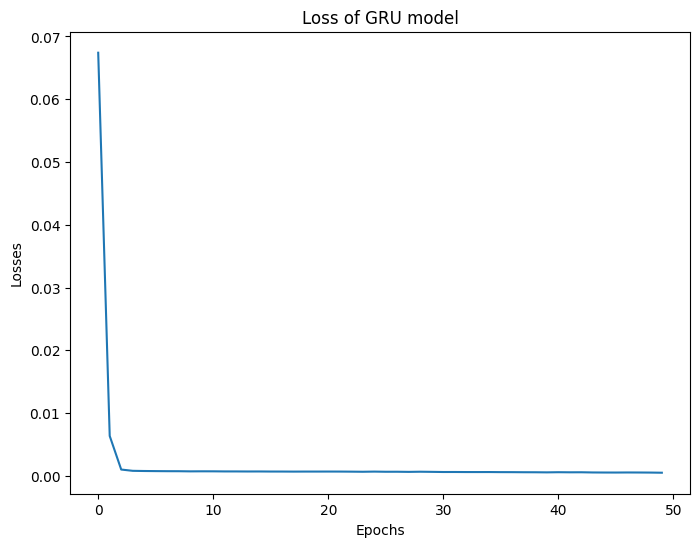

In [58]:
plt.figure(figsize =(8,6))
plt.plot(history_2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss of GRU model")
plt.show()

In [59]:
y_train_pred = GRU_model_2.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)

pred_error_train = y_train_pred - y_train_original
print(f'Max error: {np.max(np.abs(pred_error_train)):.2f}')
print(f'Min error: {np.min(np.abs(pred_error_train)):.2f}')
print(f'Mean error: {np.mean(np.abs(pred_error_train)):.2f}')

62/62 [==============================] - 1s 5ms/step
Max error: 7.13
Min error: 0.00
Mean error: 0.55


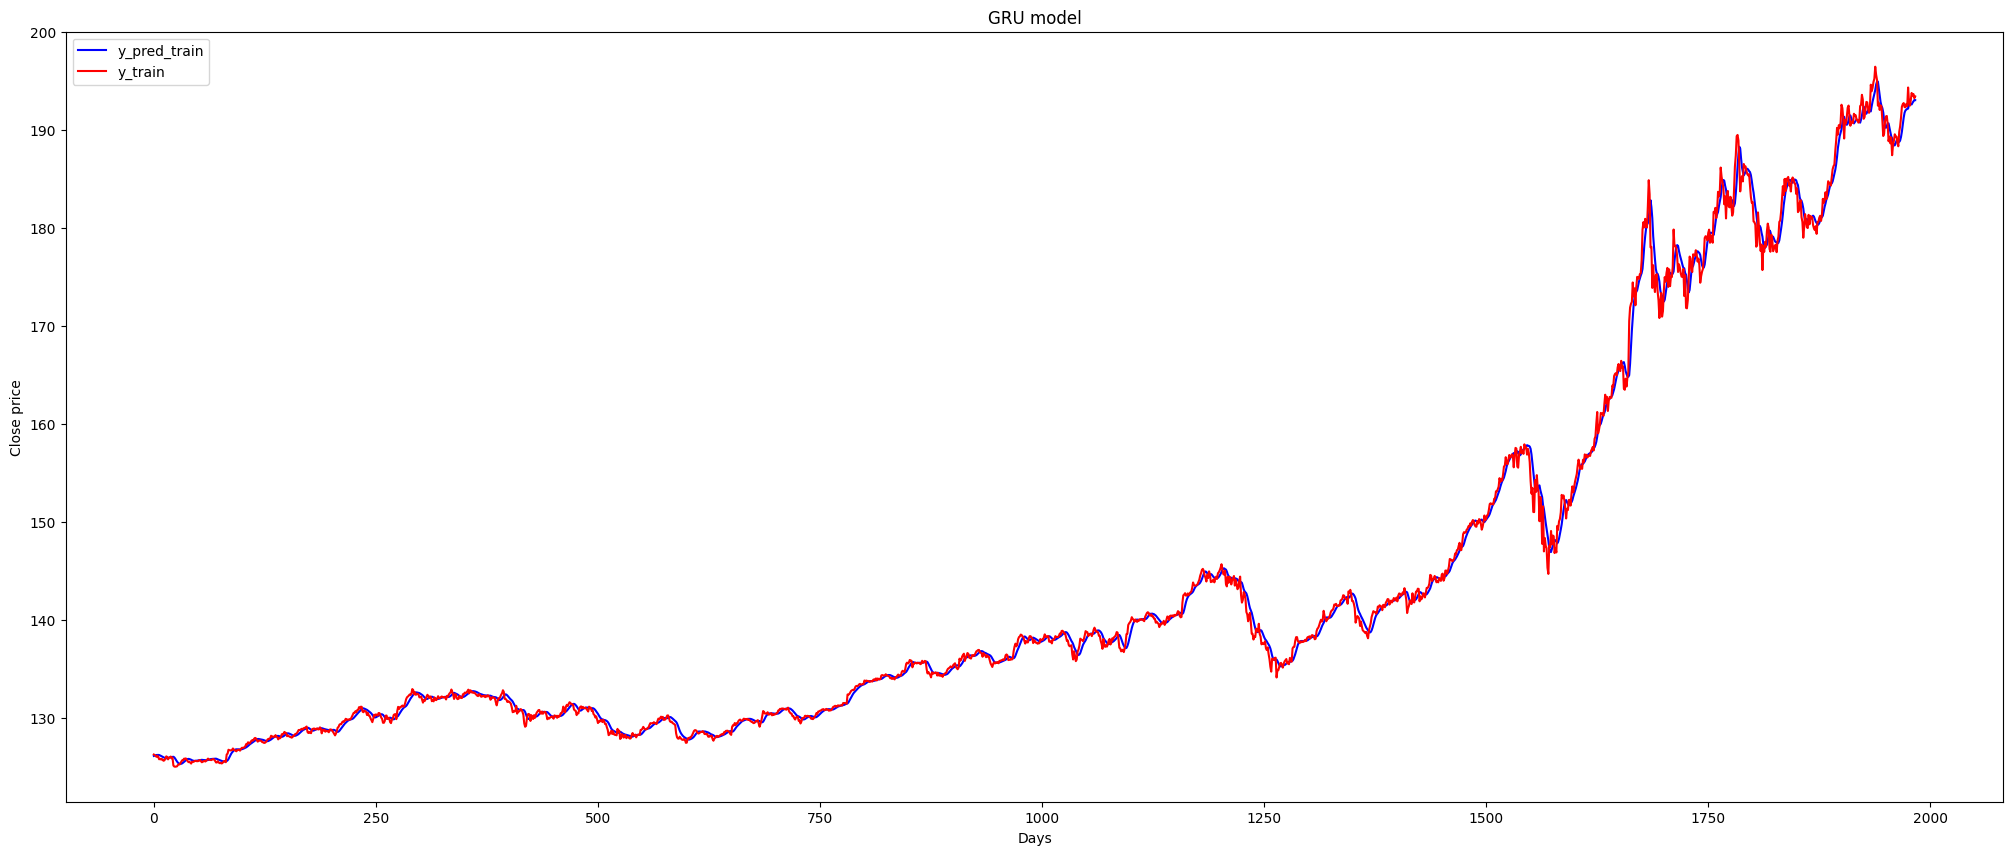

In [60]:
# visualisation
plt.figure(figsize = (25,10))
plt.plot(y_train_pred, label = "y_pred_train", c = "b")
plt.plot(y_train_original, label = "y_train", c = "r")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("GRU model")
plt.legend()
plt.show()

In [61]:
y_test_pred = GRU_model_2.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

15/15 [==============================] - 1s 5ms/step


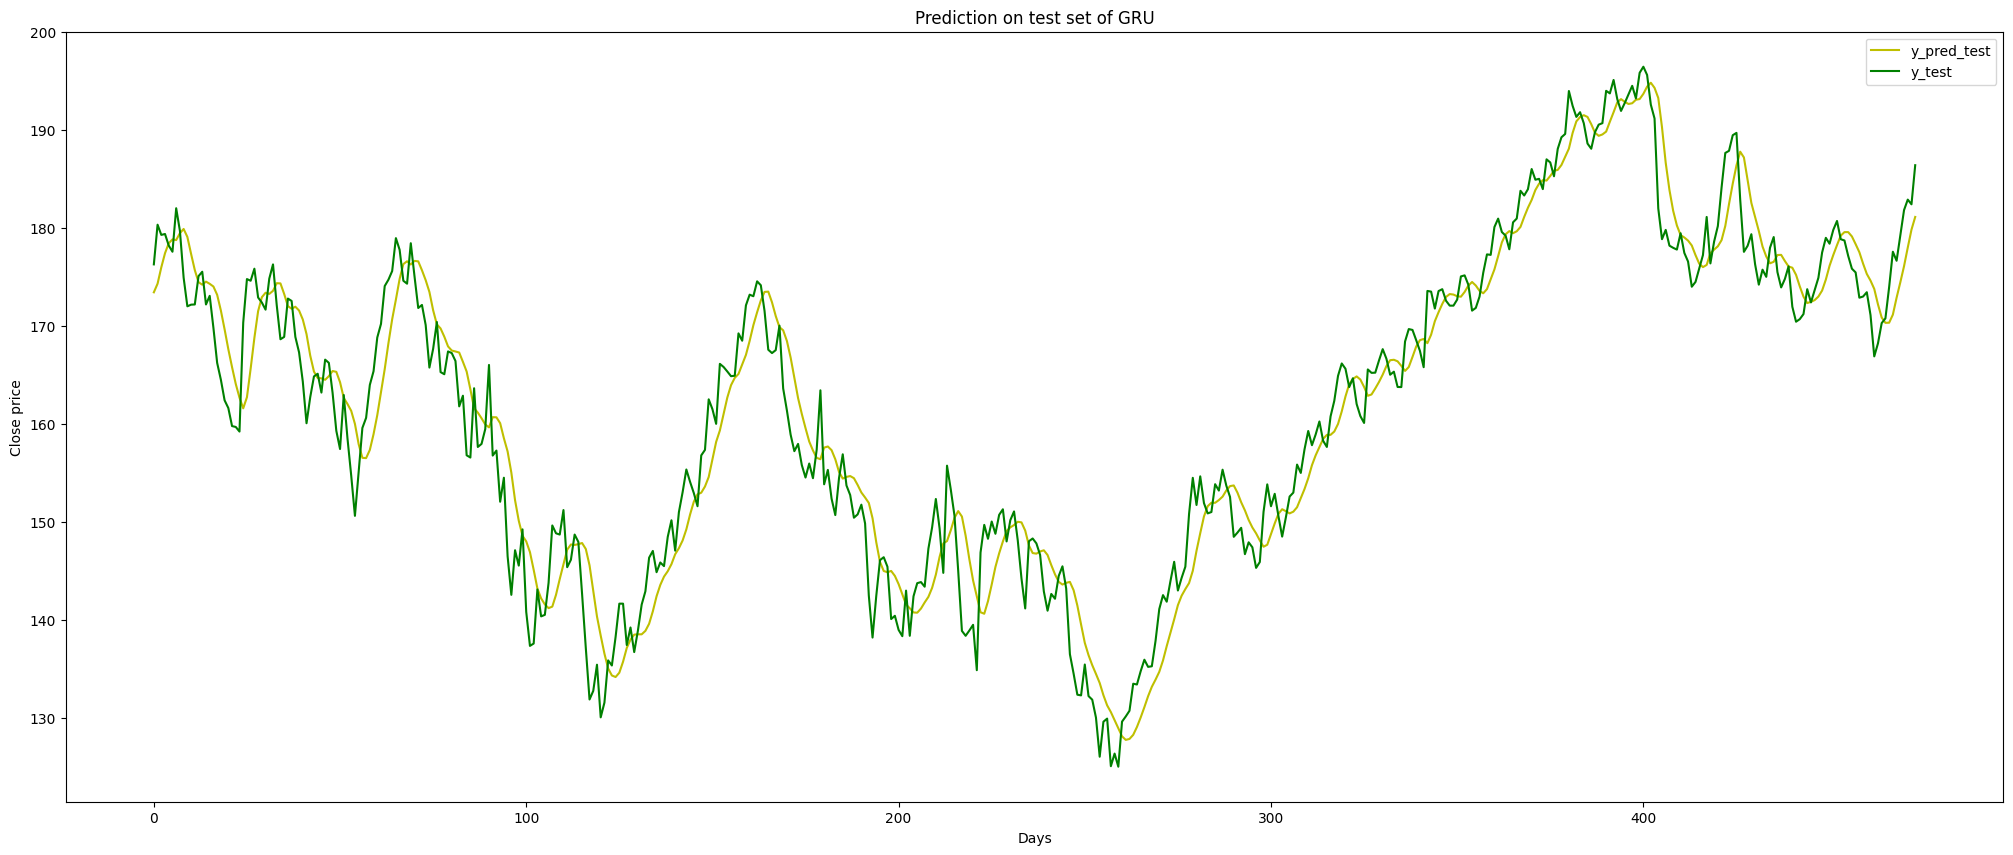

In [62]:
plt.subplots(figsize =(25,10))
plt.plot(y_test_pred, label = "y_pred_test", c = "y" )
plt.plot(y_test_original, label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Prediction on test set of GRU")
plt.legend()
plt.show()

In [63]:
GRU_pred_error = y_test_pred  - y_test_original
print(f'Max error: {np.max(np.abs(GRU_pred_error)):.2f}')
print(f'Min error: {np.min(np.abs(GRU_pred_error)):.2f}')
print(f'Mean error: {np.mean(np.abs(GRU_pred_error)):.2f}')

Max error: 13.70
Min error: 0.02
Mean error: 3.55
